# Code for running all GWAS association tests described in the manuscript based on SAIGE. First compares the P-values output by SAIGE and GMMAT for GWAS on non-imputed variants

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../code/gwas_analysis')
from gwas_plotting import manhattan, manhattan_fixwidth, qqplot

from matplotlib import rcParams, font_manager
from scipy.stats import chi2

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
idmap = pd.read_csv('gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/varidmap.tsv', sep='\t')
var2id = dict(zip(idmap['POSID'], idmap['ID']))
idmap.head()

,POSID,ID
0,"1:723918[b37]G,A",rs144434834
1,"1:724103[b37]A,G",rs111533735
2,"1:724169[b37]A,G",.
3,"1:724300[b37]C,T",rs12069907
4,"1:725286[b37]G,A",rs111203397


In [3]:
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
             'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [50]:


for p in phenotypes:
    origbase = '../../data/tmp/GWAS/results_20220311/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2'.format(p=p)
    newbase = origbase + '.FixSexChr'
    for ext in ['bed', 'bim', 'fam']:
        cmd = 'cp {o}.{ext} {n}.{ext}'.format(o=origbase, ext=ext, n=newbase)
        print(cmd)
        !{cmd}
    
    bim = pd.read_csv('{n}.bim'.format(n=newbase), sep='\t', header=None)
    bim[0] = bim[0].replace({'X':23, 'Y':24})
    bim.to_csv('{n}.bim'.format(n=newbase), sep='\t', header=False, index=False)

cp ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSL

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cp ../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim
cp ../

In [54]:
for p in phenotypes:
    cmd = "mamba activate RSAIGE\n"
    cmd += "Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R     \
        --plinkFile=../../data/tmp/GWAS/results_20220311/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr  \
        --phenoFile=../../data/tmp/GWAS/results_20220311/{p}/Covar_Pheno_UnrelatedPCs.txt \
        --phenoCol={p} \
        --covarColList=SEX,H3,PC1,PC2,PC3,PC4,PC5,PC6 \
        --qCovarColList=SEX,H3  \
        --sampleIDColinphenoFile=IID \
        --traitType=binary        \
        --outputPrefix=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE \
        --nThreads=24 \
        --IsOverwriteVarianceRatioFile=TRUE".format(p=p)
    
    
print(cmd)
        

mamba activate RSAIGE
Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr          --phenoFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/Covar_Pheno_UnrelatedPCs.txt         --phenoCol=MergeEpoch_SL_AgORSeqPos_Vs_PopControl         --covarColList=SEX,H3,PC1,PC2,PC3,PC4,PC5,PC6         --qCovarColList=SEX,H3          --sampleIDColinphenoFile=IID         --traitType=binary                --outputPrefix=../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/results/raw_gwas/SAIGE         --nThreads=24         --IsOverwriteVarianceRatioFile=TRUE


In [55]:
for p in phenotypes:
    cmd = "mamba activate RSAIGE\n"
    cmd += "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --bedFile=../../data/tmp/GWAS/results_20220311/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed       \
        --bimFile=../../data/tmp/GWAS/results_20220311/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim       \
        --famFile=../../data/tmp/GWAS/results_20220311/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.fam       \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.results.txt \
        --chrom=1       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE \
        --is_output_moreDetails=TRUE".format(p=p)
    
cmd

'mamba activate RSAIGE\nRscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R                --bedFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed               --bimFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim               --famFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.fam               --AlleleOrder=ref-first         --SAIGEOutputFile=../../data/tmp/GWAS/results_2

In [27]:
res = pd.read_csv('../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/raw_gwas/SAIGE.results.txt', sep='\t')
res.index = res['MarkerID']
res.head()

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,...,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom,N_case_het,N_ctrl_hom,N_ctrl_het
MarkerID,,,,,,,,,,,,,,,,,,,,,
1:723918:G:A,1,723918,1:723918:G:A,A,G,2885,0.902691,0.006258,0.110331,0.238058,...,0.643033,False,0.900243,0.903538,411,1187,331,78,958,229
1:752721:A:G,1,752721,1:752721:A:G,G,A,2546,0.796621,0.005632,-0.032445,0.163462,...,0.842665,False,0.793187,0.797810,411,1187,261,130,760,374
1:767677:G:A,1,767677,1:767677:G:A,A,G,2937,0.918961,0.002503,0.042217,0.245189,...,0.863296,False,0.918491,0.919124,411,1187,346,63,996,190
1:779322:A:G,1,779322,1:779322:A:G,G,A,1458,0.456195,0.008135,-0.092082,0.131205,...,0.482796,False,0.448905,0.458719,411,1187,82,205,264,561
1:785100:C:A,1,785100,1:785100:C:A,A,C,3143,0.983417,0.001252,-0.659697,0.569138,...,0.246409,False,0.984185,0.983151,411,1187,398,13,1147,40


In [28]:
origres = pd.read_csv('../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/raw_gwas/gmmat.SEXPCsH3.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.results.tsv', sep='\t')
origres.index = origres['SNP']
origres.head()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
1:723918:G:A,1:723918:G:A,1,723918,A,G,1588,0.006258,0.902078,2.017128,17.543828,0.630102
1:752721:A:G,1:752721:A:G,1,752721,G,A,1589,0.005632,0.795469,-1.060486,37.231932,0.862024
1:767677:G:A,1:767677:G:A,1,767677,A,G,1594,0.002503,0.918758,0.780197,16.538823,0.847863
1:779322:A:G,1:779322:A:G,1,779322,G,A,1585,0.008135,0.455836,-5.398686,57.771397,0.477528
1:785100:C:A,1:785100:C:A,1,785100,A,C,1596,0.001252,0.983396,-2.058826,3.080881,0.240813


In [29]:
overlap = list(set(origres.index).intersection(res.index))

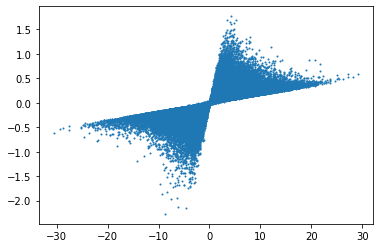

In [30]:
plt.scatter(origres.loc[overlap, 'SCORE'], res.loc[overlap, 'BETA'], s=1)

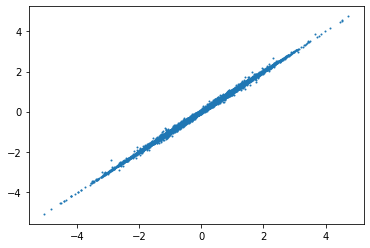

In [31]:
plt.scatter(origres.loc[overlap, 'SCORE'].apply(np.sign) * origres.loc[overlap, 'PVAL'].apply(np.log10)*-1,
            res.loc[overlap, 'BETA'].apply(np.sign) * res.loc[overlap, 'p.value.NA'].apply(np.log10)*-1, s=1)

In [57]:
res = pd.read_csv('../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.results.txt'.format(p=phenotypes[1]), sep='\t')
res.index = res['MarkerID']
res.head()

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,...,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom,N_case_het,N_ctrl_hom,N_ctrl_het
MarkerID,,,,,,,,,,,,,,,,,,,,,
1:723918:G:A,1,723918,1:723918:G:A,A,G,1705,0.925624,0.004343,-0.378897,0.311030,...,0.223147,False,0.905738,0.928661,122,799,99,23,685,114
1:752721:A:G,1,752721,1:752721:A:G,G,A,1358,0.737242,0.007600,0.149923,0.180001,...,0.404901,False,0.750000,0.735294,122,799,67,49,434,307
1:767677:G:A,1,767677,1:767677:G:A,A,G,1686,0.915309,0.004343,0.396731,0.291717,...,0.173834,False,0.926230,0.913642,122,799,104,18,661,138
1:774047:G:A,1,774047,1:774047:G:A,A,G,1817,0.986428,0.002172,-0.004194,0.653017,...,0.994876,False,0.975410,0.988110,122,799,116,6,780,19
1:779322:A:G,1,779322,1:779322:A:G,G,A,886,0.480999,0.007600,0.162098,0.158635,...,0.306864,False,0.516393,0.475594,122,799,29,68,184,392


In [59]:
origres = pd.read_csv('../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/gmmat.SEXPCsH3.{p}.results.tsv'.format(p=phenotypes[1]), sep='\t')
origres.index = origres['SNP']
origres.head()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
1:723918:G:A,1:723918:G:A,1,723918,A,G,917,0.004343,0.925300,-3.834023,10.252308,0.231146
1:752721:A:G,1:752721:A:G,1,752721,G,A,914,0.007600,0.739059,4.270781,30.441534,0.438896
1:767677:G:A,1:767677:G:A,1,767677,A,G,917,0.004343,0.914940,4.563657,11.578949,0.179871
1:774047:G:A,1:774047:G:A,1,774047,A,G,919,0.002172,0.986398,-0.000200,2.299519,0.999895
1:779322:A:G,1:779322:A:G,1,779322,G,A,914,0.007600,0.480853,6.319227,39.354595,0.313782


In [60]:
overlap = list(set(origres.index).intersection(res.index))

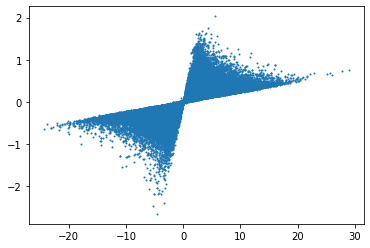

In [61]:
plt.scatter(origres.loc[overlap, 'SCORE'], res.loc[overlap, 'BETA'], s=1)

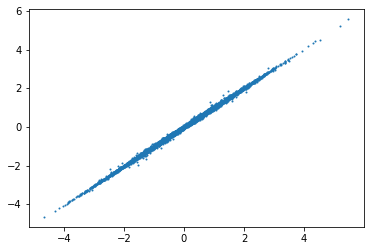

In [62]:
plt.scatter(origres.loc[overlap, 'SCORE'].apply(np.sign) * origres.loc[overlap, 'PVAL'].apply(np.log10)*-1,
            res.loc[overlap, 'BETA'].apply(np.sign) * res.loc[overlap, 'p.value.NA'].apply(np.log10)*-1, s=1)

tabix --csi -p vcf ! ls ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.chr7.vcf.gz

In [65]:
cmd = 'tabix --csi -p vcf ../../data/tmp/GWAS/results_20220311/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=phenotypes[1], chrom=17)
print(cmd)
!{cmd}

tabix --csi -p vcf ../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.chr17.vcf.gz


In [ ]:
Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.chr7.vcf.gz    \
        --vcfFileIndex=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.chr7.vcf.gz.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/imputed_gwas/SAIGE.7.results.txt \
        --chrom=7       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE \
        --is_output_moreDetails=TRUE

In [75]:
res = pd.read_csv('../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/imputed_gwas/SAIGE.7.results.txt', sep='\t')
res.index = res['MarkerID']
res.head()

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,...,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom,N_case_het,N_ctrl_hom,N_ctrl_het
MarkerID,,,,,,,,,,,,,,,,,,,,,
"7:41421[b37]A,G",7,41421,"7:41421[b37]A,G",A,G,523.0,0.163642,0,-0.074880,0.184350,...,0.684607,False,0.152068,0.167650,411,1187,9,107,33,332
"7:41888[b37]C,T",7,41888,"7:41888[b37]C,T",C,T,233.2,0.072966,0,0.624910,0.305503,...,0.020248,True,0.079866,0.070577,411,1187,0,65,4,158
"7:41892[b37]G,C",7,41892,"7:41892[b37]G,C",G,C,213.4,0.066771,0,-0.172983,0.265828,...,0.515219,False,0.051277,0.072136,411,1187,0,41,6,157
"7:41941[b37]A,T",7,41941,"7:41941[b37]A,T",A,T,37.8,0.011827,0,-1.297830,0.734583,...,0.038066,True,0.007725,0.013248,411,1187,0,6,0,32
"7:42038[b37]G,C",7,42038,"7:42038[b37]G,C",G,C,237.3,0.074249,0,0.622860,0.302491,...,0.019587,True,0.082543,0.071377,411,1187,0,67,4,160


In [76]:
origres = pd.read_csv('../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/imputed_gwas/gmmat.fromVCFdosage.SEXPCsH3.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.7.results.tsv', sep='\t')
origres.index = origres['SNP']
origres.head()

,SNP,CHR,POS,REF,ALT,N,MISSRATE,AF,SCORE,VAR,PVAL
SNP,,,,,,,,,,,
"7:41421[b37]A,G","7:41421[b37]A,G",7,41421,A,G,1598,0.000000,0.163642,-2.188734,29.306417,0.685987
"7:41888[b37]C,T","7:41888[b37]C,T",7,41888,C,T,1598,0.003755,0.072550,8.583892,13.755544,0.020644
"7:41892[b37]G,C","7:41892[b37]G,C",7,41892,G,C,1598,0.028160,0.059240,-2.426897,14.043921,0.517243
"7:41941[b37]A,T","7:41941[b37]A,T",7,41941,A,T,1598,0.005006,0.010063,-3.293471,2.542228,0.038866
"7:42038[b37]G,C","7:42038[b37]G,C",7,42038,G,C,1598,0.005006,0.073270,8.704832,13.995159,0.019972


In [77]:
overlap = list(set(origres.index).intersection(res.index))

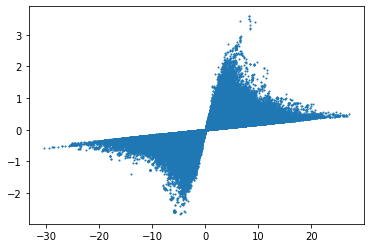

In [78]:
plt.scatter(origres.loc[overlap, 'SCORE'], res.loc[overlap, 'BETA'], s=1)

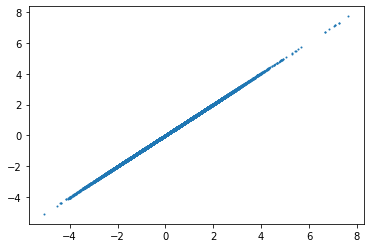

In [79]:
plt.scatter(origres.loc[overlap, 'SCORE'].apply(np.sign) * origres.loc[overlap, 'PVAL'].apply(np.log10)*-1,
            res.loc[overlap, 'BETA'].apply(np.sign) * res.loc[overlap, 'p.value.NA'].apply(np.log10)*-1, s=1)

In [80]:
res.sort_values(by='p.value.NA', ascending=True).head(10).T

MarkerID,"7:146308575[b37]T,C","7:146261329[b37]T,C","7:146262071[b37]C,T","7:146268583[b37]T,C","7:146272410[b37]T,C","7:146293176[b37]T,A","7:146324580[b37]C,T","7:146356694[b37]T,A","7:146355677[b37]T,C","7:46809156[b37]C,T"
CHR,7,7,7,7,7,7,7,7,7,7
POS,146308575,146261329,146262071,146268583,146272410,146293176,146324580,146356694,146355677,46809156
MarkerID,"7:146308575[b37]T,C","7:146261329[b37]T,C","7:146262071[b37]C,T","7:146268583[b37]T,C","7:146272410[b37]T,C","7:146293176[b37]T,A","7:146324580[b37]C,T","7:146356694[b37]T,A","7:146355677[b37]T,C","7:46809156[b37]C,T"
Allele1,T,T,C,T,T,T,C,T,T,C
Allele2,C,C,T,C,C,A,T,A,C,T
AC_Allele2,41.4,35.45,35.45,35.85,35.85,36.8,37.5,38.75,38.65,32.55
AF_Allele2,0.0129537,0.011092,0.011092,0.0112171,0.0112171,0.0115144,0.0117334,0.0121245,0.0120932,0.0101846
MissingRate,0,0,0,0,0,0,0,0,0,0
BETA,3.40619,3.5875,3.5875,3.51821,3.51821,3.44095,3.30673,3.20756,3.18666,3.44737
SE,0.723536,0.759167,0.759167,0.752554,0.752554,0.739522,0.720389,0.704935,0.701333,0.851823


In [27]:
cmds = []
for p in phenotypes:
    for chrom in list(range(1,23)) + ['X']:
        cmd = 'tabix --csi -p vcf ../../data/tmp/GWAS/results_20220311/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=p, chrom=chrom)
        cmds.append(cmd)
        cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile=../../data/tmp/GWAS/results_20220311/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz    \
        --vcfFileIndex=../../data/tmp/GWAS/results_20220311/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/results_20220311/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt \
        --chrom={chrom}       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE \
        --is_Firth_beta=TRUE       \
        --pCutoffforFirth=0.01       \
        --is_output_moreDetails=TRUE".format(p=p, chrom=chrom)
        cmds.append(cmd)
        
with open('submit_saige.sh', 'w') as F:
    F.write('\n'.join(cmds))

In [44]:
saige_res = {}
for p in phenotypes:
    country = p.split('_')[1]
    pres = []
    for chrom in list(range(1,23)) + ['X']:
        pres.append(pd.read_csv('../../data/tmp/GWAS/results_20220311/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt'.format(p=p, chrom=chrom), sep='\t'))
    saige_res[country] = pd.concat(pres, axis=0)
    saige_res[country].index = saige_res[country]['MarkerID']


In [45]:
for p in phenotypes:
    country = p.split('_')[1]
    saige_res[country]['N'] = saige_res[country]['N_case'] + saige_res[country]['N_ctrl']
    saige_res[country].to_csv('../../data/tmp/GWAS/results_20220311/{p}/results/SAIGE.merged.results.txt'.format(p=p, chrom=chrom), sep='\t', index=False)


In [20]:
saige_res['NG'].sort_values(by='p.value').iloc[:10, :20]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom
MarkerID,,,,,,,,,,,,,,,,,,,,
"14:98241845[b37]G,C",14,98241845,"14:98241845[b37]G,C",G,C,729.45,0.228238,0,0.723631,0.152270,31.45320,40.25060,0.000001,7.134035e-07,True,0.264355,0.215733,411,1187,33
"7:146261329[b37]T,C",7,146261329,"7:146261329[b37]T,C",T,C,35.45,0.011092,0,2.435100,0.515304,8.32143,2.31956,0.000001,4.660536e-08,True,0.022080,0.007287,411,1187,0
"7:146262071[b37]C,T",7,146262071,"7:146262071[b37]C,T",C,T,35.45,0.011092,0,2.435100,0.515304,8.32143,2.31956,0.000001,4.660536e-08,True,0.022080,0.007287,411,1187,0
"7:146308575[b37]T,C",7,146308575,"7:146308575[b37]T,C",T,C,41.40,0.012954,0,2.135270,0.453571,9.29510,2.72889,0.000001,1.835843e-08,True,0.023479,0.009309,411,1187,0
"3:27919217[b37]A,C",3,27919217,"3:27919217[b37]A,C",A,C,38.60,0.012078,0,2.565290,0.545832,7.95103,2.33715,0.000001,1.983017e-07,True,0.023662,0.008067,411,1187,0
"7:146272410[b37]T,C",7,146272410,"7:146272410[b37]T,C",T,C,35.85,0.011217,0,2.400170,0.513402,8.26852,2.35020,0.000001,6.907755e-08,True,0.022080,0.007456,411,1187,0
"7:146268583[b37]T,C",7,146268583,"7:146268583[b37]T,C",T,C,35.85,0.011217,0,2.400170,0.513402,8.26852,2.35020,0.000001,6.907755e-08,True,0.022080,0.007456,411,1187,0
"3:8668113[b37]C,T",3,8668113,"3:8668113[b37]C,T",C,T,105.15,0.032900,0,1.577390,0.337937,13.00570,6.64517,0.000002,4.529552e-07,True,0.054623,0.025379,411,1187,0
"7:146293176[b37]T,A",7,146293176,"7:146293176[b37]T,A",T,A,36.80,0.011514,0,2.336140,0.502078,8.38257,2.43612,0.000002,7.844610e-08,True,0.022202,0.007814,411,1187,0


In [5]:
saige_res['SL'].sort_values(by='p.value').iloc[:10, :20]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom
MarkerID,,,,,,,,,,,,,,,,,,,,
"17:68745251[b37]C,G",17,68745251,"17:68745251[b37]C,G",C,G,44.65,0.024240,0,2.21522,0.417123,12.0487,4.14702,5.460241e-08,3.287114e-09,True,0.078688,0.015926,122,799,1
"17:33192408[b37]C,G",17,33192408,"17:33192408[b37]C,G",C,G,50.50,0.027416,0,1.92720,0.371435,13.0927,4.77878,1.059844e-07,2.108275e-09,True,0.086066,0.018461,122,799,1
"17:33371615[b37]A,G",17,33371615,"17:33371615[b37]A,G",A,G,61.95,0.033632,0,1.72681,0.340922,13.9424,5.74400,2.040733e-07,5.975831e-09,True,0.096926,0.023968,122,799,1
"17:33266080[b37]G,A",17,33266080,"17:33266080[b37]G,A",G,A,52.70,0.028610,0,1.81309,0.360441,13.0473,4.99641,2.449970e-07,5.313357e-09,True,0.088115,0.019524,122,799,1
"17:33266081[b37]C,A",17,33266081,"17:33266081[b37]C,A",C,A,52.70,0.028610,0,1.81309,0.360441,13.0473,4.99641,2.449970e-07,5.313357e-09,True,0.088115,0.019524,122,799,1
"17:33410168[b37]C,T",17,33410168,"17:33410168[b37]C,T",C,T,61.30,0.033279,0,1.73441,0.347711,13.4484,5.53305,3.049059e-07,1.082424e-08,True,0.095082,0.023842,122,799,1
"17:33386505[b37]T,C",17,33386505,"17:33386505[b37]T,C",T,C,58.60,0.031813,0,1.72895,0.353211,13.0293,5.46309,4.916679e-07,2.482987e-08,True,0.090984,0.022779,122,799,1
"17:33381303[b37]C,T",17,33381303,"17:33381303[b37]C,T",C,T,59.50,0.032302,0,1.68574,0.345215,13.2560,5.61337,5.219641e-07,2.205987e-08,True,0.092213,0.023154,122,799,1
"17:33339333[b37]C,T",17,33339333,"17:33339333[b37]C,T",C,T,60.20,0.032682,0,1.69305,0.347095,13.2981,5.77172,5.364577e-07,3.108209e-08,True,0.093443,0.023404,122,799,1


In [3]:
44.65 / ((122+799)*2)

0.024239956568946796

In [2]:
0.024240*((122+799)*2)

44.65008

In [18]:
idmap = pd.read_csv('gs://popgen-gwas/data/genotype/merge/Imputed_Plink2/varidmap.tsv', sep='\t')
var2id = dict(zip(idmap['POSID'], idmap['ID']))
idmap.head()

,POSID,ID
0,"1:723918[b37]G,A",rs144434834
1,"1:724103[b37]A,G",rs111533735
2,"1:724169[b37]A,G",.
3,"1:724300[b37]C,T",rs12069907
4,"1:725286[b37]G,A",rs111203397


In [26]:
p = 'SL'
snps = ['7:146356694[b37]T,A', '17:68745251[b37]C,G', '17:33192408[b37]C,G', ]
for snp in snps:
    print('SNP: %s. ID %s' % (snp, var2id[snp]))
    print('OR %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA']), 4))
    print('P %.4e' % saige_res[p].loc[snp, 'p.value'])

    print('Lower CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] - 1.96*saige_res[p].loc[snp, 'SE']), 4))
    print('Upper CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] + 1.96*saige_res[p].loc[snp, 'SE']), 4))
    print('\n\n')

SNP: 7:146356694[b37]T,A. ID rs114992845
OR 4.765
P 1.0182e-02
Lower CI 1.274
Upper CI 17.826



SNP: 17:68745251[b37]C,G. ID rs73397758
OR 9.163
P 5.4602e-08
Lower CI 4.046
Upper CI 20.755



SNP: 17:33192408[b37]C,G. ID rs143130878
OR 6.870
P 1.0598e-07
Lower CI 3.317
Upper CI 14.228





In [27]:
p = 'NG'
snps = ['7:146356694[b37]T,A', '17:68745251[b37]C,G', '17:33192408[b37]C,G', ]
for snp in snps:
    print('SNP: %s. ID %s' % (snp, var2id[snp]))
    print('OR %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA']), 4))
    print('P %.4e' % saige_res[p].loc[snp, 'p.value'])

    print('Lower CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] - 1.96*saige_res[p].loc[snp, 'SE']), 4))
    print('Upper CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] + 1.96*saige_res[p].loc[snp, 'SE']), 4))
    print('\n\n')

SNP: 7:146356694[b37]T,A. ID rs114992845
OR 9.185
P 2.6804e-06
Lower CI 3.534
Upper CI 23.873



SNP: 17:68745251[b37]C,G. ID rs73397758
OR 0.842
P 5.5795e-01
Lower CI 0.474
Upper CI 1.496



SNP: 17:33192408[b37]C,G. ID rs143130878
OR 1.199
P 6.3739e-01
Lower CI 0.563
Upper CI 2.552





In [28]:
saige_res['NG'].loc['14:98241845[b37]G,C', :]

CHR                             14
POS                       98241845
MarkerID       14:98241845[b37]G,C
Allele1                          G
Allele2                          C
AC_Allele2                  729.45
AF_Allele2                0.228238
MissingRate                      0
BETA                      0.723631
SE                         0.15227
Tstat                      31.4532
var                        40.2506
p.value                1.00561e-06
p.value.NA             7.13404e-07
Is.SPA                        True
AF_case                   0.264355
AF_ctrl                   0.215733
N_case                         411
N_ctrl                        1187
N_case_hom                      33
N_case_het                     150
N_ctrl_hom                      55
N_ctrl_het                     400
N                             1598
Name: 14:98241845[b37]G,C, dtype: object

In [10]:
saige_res['NG'].loc['7:146262071[b37]C,T', :]

CHR                              7
POS                      146262071
MarkerID       7:146262071[b37]C,T
Allele1                          C
Allele2                          T
AC_Allele2                   35.45
AF_Allele2                0.011092
MissingRate                      0
BETA                        2.4351
SE                        0.515304
Tstat                      8.32143
var                        2.31956
p.value                1.14736e-06
p.value.NA             4.66054e-08
Is.SPA                        True
AF_case                  0.0220803
AF_ctrl                 0.00728728
N_case                         411
N_ctrl                        1187
N_case_hom                       0
N_case_het                      19
N_ctrl_hom                       0
N_ctrl_het                      15
N                             1598
Name: 7:146262071[b37]C,T, dtype: object

In [29]:
saige_res['SL'].loc['7:146262071[b37]C,T', :]

CHR                              7
POS                      146262071
MarkerID       7:146262071[b37]C,T
Allele1                          C
Allele2                          T
AC_Allele2                    64.8
AF_Allele2               0.0351792
MissingRate                      0
BETA                      0.510718
SE                        0.441274
Tstat                      2.62279
var                        5.13551
p.value                   0.247121
p.value.NA                0.247121
Is.SPA                       False
AF_case                  0.0479508
AF_ctrl                   0.033229
N_case                         122
N_ctrl                         799
N_case_hom                       0
N_case_het                      11
N_ctrl_hom                       1
N_ctrl_het                      54
N                              921
Name: 7:146262071[b37]C,T, dtype: object

In [30]:
saige_res['NG'].loc['7:146356694[b37]T,A', :]

CHR                              7
POS                      146356694
MarkerID       7:146356694[b37]T,A
Allele1                          T
Allele2                          A
AC_Allele2                   38.75
AF_Allele2               0.0121245
MissingRate                      0
BETA                       2.21753
SE                        0.487353
Tstat                       8.4943
var                        2.64821
p.value                2.68035e-06
p.value.NA             1.79146e-07
Is.SPA                        True
AF_case                  0.0229319
AF_ctrl                 0.00838248
N_case                         411
N_ctrl                        1187
N_case_hom                       0
N_case_het                      19
N_ctrl_hom                       0
N_ctrl_het                      20
N                             1598
Name: 7:146356694[b37]T,A, dtype: object

In [31]:
saige_res['SL'].loc['7:146356694[b37]T,A', :]

CHR                              7
POS                      146356694
MarkerID       7:146356694[b37]T,A
Allele1                          T
Allele2                          A
AC_Allele2                    34.2
AF_Allele2               0.0185668
MissingRate                      0
BETA                       1.56135
SE                        0.673122
Tstat                      4.20929
var                        2.69593
p.value                  0.0101821
p.value.NA               0.0103585
Is.SPA                        True
AF_case                  0.0422131
AF_ctrl                  0.0149562
N_case                         122
N_ctrl                         799
N_case_hom                       0
N_case_het                      11
N_ctrl_hom                       0
N_ctrl_het                      26
N                              921
Name: 7:146356694[b37]T,A, dtype: object

In [48]:
saige_res['NG'].loc['22:30619983[b37]G,A', :]

CHR                             22
POS                       30619983
MarkerID       22:30619983[b37]G,A
Allele1                          G
Allele2                          A
AC_Allele2                  1569.6
AF_Allele2                0.491114
MissingRate                      0
BETA                     -0.183374
SE                         0.13744
Tstat                     -9.70763
var                         52.939
p.value                   0.182134
p.value.NA                0.182134
Is.SPA                       False
AF_case                   0.469526
AF_ctrl                   0.498589
N_case                         411
N_ctrl                        1187
N_case_hom                      88
N_case_het                     212
N_ctrl_hom                     291
N_ctrl_het                     604
N                             1598
Name: 22:30619983[b37]G,A, dtype: object

In [49]:
saige_res['SL'].loc['22:30619983[b37]G,A', :]

CHR                             22
POS                       30619983
MarkerID       22:30619983[b37]G,A
Allele1                          G
Allele2                          A
AC_Allele2                   659.6
AF_Allele2                0.358089
MissingRate                      0
BETA                     -0.346558
SE                        0.196556
Tstat                     -12.3098
var                        35.5201
p.value                  0.0389376
p.value.NA               0.0388809
Is.SPA                        True
AF_case                   0.301434
AF_ctrl                    0.36674
N_case                         122
N_ctrl                         799
N_case_hom                      13
N_case_het                      48
N_ctrl_hom                     106
N_ctrl_het                     375
N                              921
Name: 22:30619983[b37]G,A, dtype: object

In [50]:
saige_res['SL'].sort_values(by='p.value').iloc[:10, :20]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom
MarkerID,,,,,,,,,,,,,,,,,,,,
"17:68745251[b37]C,G",17,68745251,"17:68745251[b37]C,G",C,G,44.65,0.024240,0,2.21522,0.417123,12.0487,4.14702,5.460241e-08,3.287114e-09,True,0.078688,0.015926,122,799,1
"17:33192408[b37]C,G",17,33192408,"17:33192408[b37]C,G",C,G,50.50,0.027416,0,1.92720,0.371435,13.0927,4.77878,1.059844e-07,2.108275e-09,True,0.086066,0.018461,122,799,1
"17:33371615[b37]A,G",17,33371615,"17:33371615[b37]A,G",A,G,61.95,0.033632,0,1.72681,0.340922,13.9424,5.74400,2.040733e-07,5.975831e-09,True,0.096926,0.023968,122,799,1
"17:33266080[b37]G,A",17,33266080,"17:33266080[b37]G,A",G,A,52.70,0.028610,0,1.81309,0.360441,13.0473,4.99641,2.449970e-07,5.313357e-09,True,0.088115,0.019524,122,799,1
"17:33266081[b37]C,A",17,33266081,"17:33266081[b37]C,A",C,A,52.70,0.028610,0,1.81309,0.360441,13.0473,4.99641,2.449970e-07,5.313357e-09,True,0.088115,0.019524,122,799,1
"17:33410168[b37]C,T",17,33410168,"17:33410168[b37]C,T",C,T,61.30,0.033279,0,1.73441,0.347711,13.4484,5.53305,3.049059e-07,1.082424e-08,True,0.095082,0.023842,122,799,1
"17:33386505[b37]T,C",17,33386505,"17:33386505[b37]T,C",T,C,58.60,0.031813,0,1.72895,0.353211,13.0293,5.46309,4.916679e-07,2.482987e-08,True,0.090984,0.022779,122,799,1
"17:33381303[b37]C,T",17,33381303,"17:33381303[b37]C,T",C,T,59.50,0.032302,0,1.68574,0.345215,13.2560,5.61337,5.219641e-07,2.205987e-08,True,0.092213,0.023154,122,799,1
"17:33339333[b37]C,T",17,33339333,"17:33339333[b37]C,T",C,T,60.20,0.032682,0,1.69305,0.347095,13.2981,5.77172,5.364577e-07,3.108209e-08,True,0.093443,0.023404,122,799,1


In [10]:
saige_res['NG'].loc[['7:146356694[b37]T,A', '17:68745251[b37]C,G', '17:33192408[b37]C,G'] , :]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,...,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom,N_case_het,N_ctrl_hom,N_ctrl_het,N
MarkerID,,,,,,,,,,,,,,,,,,,,,
"7:146356694[b37]T,A",7,146356694,"7:146356694[b37]T,A",T,A,38.75,0.012124,0,2.217530,0.487353,...,True,0.022932,0.008382,411,1187,0,19,0,20,1598
"17:68745251[b37]C,G",17,68745251,"17:68745251[b37]C,G",C,G,200.65,0.062782,0,-0.171773,0.293182,...,False,0.059124,0.064048,411,1187,0,49,6,136,1598
"17:33192408[b37]C,G",17,33192408,"17:33192408[b37]C,G",C,G,107.85,0.033745,0,0.181646,0.385378,...,False,0.036314,0.032856,411,1187,0,31,2,76,1598


In [3]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
OUTFILE ./meta_analysis.tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt

ANALYZE 
"""

with open('meta_suscept.cmd', 'w') as F:
    F.write(cmd)
    
! ../../code/generic-metal/metal meta_suscept.cmd

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [4]:
! cp METAANALYSIS1.TBL /mnt/disks/gwas/data/tmp/GWAS/results_20220311/METAL_Metaanalysis.tsv

In [5]:
meta = pd.read_csv('/mnt/disks/gwas/data/tmp/GWAS/results_20220311/METAL_Metaanalysis.tsv', sep='\t')
meta.head()

,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction
0,"4:134535101[b37]C,T",t,c,2519.0,0.338,0.73510,-+
1,"1:240771780[b37]G,C",c,g,2519.0,1.692,0.09068,++
2,"8:81101490[b37]T,C",t,c,2519.0,0.676,0.49900,++
3,"4:21809189[b37]A,G",a,g,2519.0,-1.272,0.20340,--
4,"5:40229384[b37]C,T",t,c,1598.0,0.507,0.61240,+?


In [6]:
meta = meta.rename(columns={'P-value':'p.value'})

In [7]:
meta['CHR'] = meta['MarkerName'].apply(lambda x: x.split(':')[0]).replace({'X':23}).astype(int)
meta['POS'] = meta['MarkerName'].apply(lambda x: x.split(':')[1].split('[')[0]).astype(int)
meta = meta.sort_values(by=['CHR', 'POS'], ascending=True)
meta['CHR'] = meta['CHR'].astype(str).replace({'23':'X'})

In [8]:
meta.to_csv('/mnt/disks/gwas/data/tmp/GWAS/results_20220311/METAL_Metaanalysis_Cleaned.tsv', sep='\t', index=False)

In [ ]:
saige_res['Meta'] = meta

In [57]:
saige_res = {}
for p in phenotypes:
    country = p.split('_')[1]
    saige_res[country] = pd.read_csv('../../data/tmp/GWAS/results_20220311/{p}/results/SAIGE.merged.results.txt'.format(p=p), sep='\t')
    saige_res[country].index = saige_res[country]['MarkerID']


In [58]:
saige_res['Meta'] = pd.read_csv('../../data/tmp/GWAS/results_20220311/METAL_Metaanalysis_Cleaned.tsv', sep='\t', index_col=0)

In [12]:
saige_res['Meta'].head()

,Allele1,Allele2,Weight,Zscore,p.value,Direction,CHR,POS
MarkerName,,,,,,,,
"1:723918[b37]G,A",a,g,2519.0,-0.367,0.7133,+-,1,723918
"1:724169[b37]A,G",a,g,2519.0,0.149,0.8815,-+,1,724169
"1:725286[b37]G,A",a,g,2519.0,0.808,0.4192,++,1,725286
"1:726797[b37]T,C",t,c,1598.0,0.114,0.9094,+?,1,726797
"1:729940[b37]C,G",c,g,2519.0,-0.457,0.6478,--,1,729940


In [13]:
full_phenotypes = ['NG', 'SL', 'Meta']

In [14]:
saige_res['NG'].head()

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,...,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom,N_case_het,N_ctrl_hom,N_ctrl_het,N
MarkerID,,,,,,,,,,,,,,,,,,,,,
"1:723918[b37]G,A",1,723918,"1:723918[b37]G,A",G,A,311.00,0.097309,0,-0.110331,0.238058,...,False,0.099757,0.096462,411,1187,2,78,0,229,1598
"1:724169[b37]A,G",1,724169,"1:724169[b37]A,G",A,G,51.10,0.015989,0,-0.404402,0.601175,...,False,0.016606,0.015775,411,1187,0,13,0,36,1598
"1:725286[b37]G,A",1,725286,"1:725286[b37]G,A",G,A,59.15,0.018507,0,-0.169623,0.510334,...,False,0.018552,0.018492,411,1187,0,15,1,41,1598
"1:726797[b37]T,C",1,726797,"1:726797[b37]T,C",T,C,48.75,0.015253,0,0.067855,0.596222,...,False,0.016910,0.014680,411,1187,0,14,0,34,1598
"1:729940[b37]C,G",1,729940,"1:729940[b37]C,G",C,G,397.20,0.124280,0,-0.040873,0.213351,...,False,0.115024,0.127485,411,1187,3,88,14,277,1598


In [15]:
meta.sort_values(by='p.value').head(10)

,MarkerName,Allele1,Allele2,Weight,Zscore,p.value,Direction,CHR,POS
4524847,"7:146356694[b37]T,A",a,t,2519.0,-5.292,1.208000e-07,--,7,146356694
11865511,"7:146355677[b37]T,C",t,c,2519.0,5.256,1.471000e-07,++,7,146355677
12494813,"7:146308575[b37]T,C",t,c,2519.0,5.215,1.835000e-07,++,7,146308575
4557432,"7:146324580[b37]C,T",t,c,2519.0,-5.199,2.006000e-07,--,7,146324580
3590578,"7:146293176[b37]T,A",a,t,2519.0,-5.128,2.921000e-07,--,7,146293176
92602,"1:209658594[b37]A,G",a,g,921.0,4.935,7.996000e-07,?+,1,209658594
11444491,"3:175274222[b37]G,A",a,g,2519.0,-4.927,8.359000e-07,--,3,175274222
10471837,"9:6734997[b37]T,A",a,t,2519.0,-4.897,9.743000e-07,--,9,6734997
9020396,"3:175274513[b37]C,T",t,c,2519.0,-4.872,1.107000e-06,--,3,175274513
5913588,"3:175274579[b37]C,A",a,c,2519.0,-4.869,1.120000e-06,--,3,175274579


In [16]:
meta.index = meta['MarkerName']

In [19]:
for snp in ['7:146356694[b37]T,A', '17:33192408[b37]C,G', '17:68745251[b37]C,G']:
    for p in ['Meta', 'NG', 'SL']:
        print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
        print('P %.4e' % saige_res[p].loc[snp, 'p.value'])

    
        if p != 'Meta':
            print('OR %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA']), 4))
            print('Lower CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] - 1.96*saige_res[p].loc[snp, 'SE']), 4))
            print('Upper CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] + 1.96*saige_res[p].loc[snp, 'SE']), 4))
            print('AF %.5f' % saige_res[p].loc[snp, 'AF_Allele2'])
    
        print('\n\n')

Pheno: Meta. SNP: 7:146356694[b37]T,A. ID rs114992845
P 1.2080e-07



Pheno: NG. SNP: 7:146356694[b37]T,A. ID rs114992845
P 2.6804e-06
OR 9.185
Lower CI 3.534
Upper CI 23.873
AF 0.01212



Pheno: SL. SNP: 7:146356694[b37]T,A. ID rs114992845
P 1.0182e-02
OR 4.765
Lower CI 1.274
Upper CI 17.826
AF 0.01857



Pheno: Meta. SNP: 17:33192408[b37]C,G. ID rs143130878
P 3.3080e-04



Pheno: NG. SNP: 17:33192408[b37]C,G. ID rs143130878
P 6.3739e-01
OR 1.199
Lower CI 0.563
Upper CI 2.552
AF 0.03375



Pheno: SL. SNP: 17:33192408[b37]C,G. ID rs143130878
P 1.0598e-07
OR 6.870
Lower CI 3.317
Upper CI 14.228
AF 0.02742



Pheno: Meta. SNP: 17:68745251[b37]C,G. ID rs73397758
P 4.8010e-03



Pheno: NG. SNP: 17:68745251[b37]C,G. ID rs73397758
P 5.5795e-01
OR 0.842
Lower CI 0.474
Upper CI 1.496
AF 0.06278



Pheno: SL. SNP: 17:68745251[b37]C,G. ID rs73397758
P 5.4602e-08
OR 9.163
Lower CI 4.046
Upper CI 20.755
AF 0.02424





In [21]:
for snp in ['22:30619983[b37]G,A', '3:7330265[b37]A,G']:
    for p in ['Meta', 'NG', 'SL']:
        print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
        print('P %.4e' % saige_res[p].loc[snp, 'p.value'])

    
        if p != 'Meta':
            print('OR %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA']), 4))
            print('Lower CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] - 1.96*saige_res[p].loc[snp, 'SE']), 4))
            print('Upper CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] + 1.96*saige_res[p].loc[snp, 'SE']), 4))
            print('AF %.5f' % saige_res[p].loc[snp, 'AF_Allele2'])
    
        print('\n\n')

Pheno: Meta. SNP: 22:30619983[b37]G,A. ID rs73404538
P 2.0820e-02



Pheno: NG. SNP: 22:30619983[b37]G,A. ID rs73404538
P 1.8213e-01
OR 0.833
Lower CI 0.636
Upper CI 1.090
AF 0.49111



Pheno: SL. SNP: 22:30619983[b37]G,A. ID rs73404538
P 3.8938e-02
OR 0.707
Lower CI 0.481
Upper CI 1.040
AF 0.35809



Pheno: Meta. SNP: 3:7330265[b37]A,G. ID rs9870087
P 6.6540e-01



Pheno: NG. SNP: 3:7330265[b37]A,G. ID rs9870087
P 2.7232e-01
OR 0.721
Lower CI 0.402
Upper CI 1.293
AF 0.05541



Pheno: SL. SNP: 3:7330265[b37]A,G. ID rs9870087
P 4.6490e-01
OR 1.384
Lower CI 0.579
Upper CI 3.307
AF 0.03094





In [25]:
snp = '7:146262071[b37]C,T'
for p in ['Meta', 'NG', 'SL']:
    print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
    print('P %.4e' % saige_res[p].loc[snp, 'p.value'])

    if p != 'Meta':
        print('OR %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA']), 4))
        print('Lower CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] - 1.96*saige_res[p].loc[snp, 'SE']), 4))
        print('Upper CI %.3f' % np.round(np.exp(saige_res[p].loc[snp, 'BETA'] + 1.96*saige_res[p].loc[snp, 'SE']), 4))
        print('AF %.4f' % saige_res[p].loc[snp, 'AF_Allele2'])
    
    print('\n\n')

Pheno: Meta. SNP: 7:146262071[b37]C,T. ID rs150484921
P 4.7780e-06



Pheno: NG. SNP: 7:146262071[b37]C,T. ID rs150484921
P 1.1474e-06
OR 11.417
Lower CI 4.158
Upper CI 31.346
AF 0.0111



Pheno: SL. SNP: 7:146262071[b37]C,T. ID rs150484921
P 2.4712e-01
OR 1.667
Lower CI 0.702
Upper CI 3.958
AF 0.0352





In [26]:
p = 'Meta'
snps = ['7:146356694[b37]T,A', '17:68745251[b37]C,G', '17:33192408[b37]C,G', ]
for snp in snps:
    print('%s: P %.4e' % (snp, saige_res[p].loc[snp, 'p.value']))

7:146356694[b37]T,A: P 1.2080e-07
17:68745251[b37]C,G: P 4.8010e-03
17:33192408[b37]C,G: P 3.3080e-04


In [27]:
title_map = {'NG':'Nigeria', 'SL':'Sierra Leone', 'Meta':'Meta-analysis'}

In [ ]:
for p in full_phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(1.75,1.75), dpi=300)
    P = saige_res[p]['p.value'].dropna().values.reshape(-1)
    ax = qqplot(P, num_top_points=1000, numsample=50000, fill_dens=0.2, title=title_map[p],ax=ax, dot_size=3, rasterized=True)
    
    if p == 'NG':
        ax.set_xticks([1,3,5,7,9])
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])
    else:
        ax.set_xticks([1,3,5,7,9])
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])
        
    ax.set_xlabel('Expected Quantile')
    ax.set_ylabel('Observed Quantile')
    
    gc = np.median(chi2.ppf(1-saige_res[p]['p.value'].dropna(), df=1)) / chi2.ppf(.5, df=1)

    
    plt.figtext(.19, .7, '$\lambda_{gc}$ = %.3f' % gc, fontsize=8)

    
    outbase = "../../figures/SAIGE_" + p + "_qqplot_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [ ]:
chroms = [str(x) for x in range(1,23)]+['X'] 
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'

for p in full_phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(5.5,1.75), dpi=300)
    ind = ~saige_res[p]['p.value'].isnull()
    P = saige_res[p].loc[ind,'p.value'].values
    logP = -1*np.log10(P)
    bp = saige_res[p].loc[ind,'POS'].values
    chrs = saige_res[p].loc[ind, 'CHR'].astype(str).values
    manhattan_fixwidth(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=0, dotsize=5, spacer=.2,
             xlabel='', title='', only_altticks=True, rasterized=True)
    xlim = ax.get_xlim()
    ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray', lw=0.4, zorder=-10)

    if p == 'NG':
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    else:
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    
    ax.set_xlabel('Genome Position')
    ax.set_title(title_map[p])
    
    
    outbase = "../../figures/SAIGE_" + p + "_manhattan_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [ ]:
chroms = [str(x) for x in range(1,23)]+['X'] 
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'

for p in ['Meta']:
    (fig,ax) = plt.subplots(1,1, figsize=(5.5,1.75), dpi=300)
    ind = ~saige_res[p]['p.value'].isnull()
    P = saige_res[p].loc[ind,'p.value'].values
    logP = -1*np.log10(P)
    bp = saige_res[p].loc[ind,'POS'].values
    chrs = saige_res[p].loc[ind, 'CHR'].astype(str).values
    manhattan_fixwidth(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=0, dotsize=5, spacer=.2,
             xlabel='', title='', only_altticks=True, rasterized=True)
    xlim = ax.get_xlim()
    ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray', lw=0.4, zorder=-10)

    if p == 'NG':
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    else:
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    
    ax.set_xlabel('Genome Position')
    ax.set_title(title_map[p])
    
    
    outbase = "../../figures/SAIGE_" + p + "_manhattan_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [100]:
saige_res['SL'].loc[['17:68745251[b37]C,G', '17:33192408[b37]C,G'], ['AF_case', 'AF_ctrl']]

,AF_case,AF_ctrl
MarkerID,,
"17:68745251[b37]C,G",0.078688,0.015926
"17:33192408[b37]C,G",0.086066,0.018461


In [101]:
saige_res['NG'].loc[['7:146356694[b37]T,A'], ['AF_case', 'AF_ctrl']]

,AF_case,AF_ctrl
MarkerID,,
"7:146356694[b37]T,A",0.022932,0.008382


In [102]:
0.022932 / 0.008382

2.735862562634216

In [ ]:
rs73397758 MAF of 1.6% in controls and 7.9% in cases, rs143130878 MAF of 1.8% in controls 8.6% in cases

## Susceptibility + Age

In [42]:
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
             'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [43]:

for p in phenotypes:
    origbase = '../../data/tmp/GWAS/results_20230715_Age/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2'.format(p=p)
    newbase = origbase + '.FixSexChr'
    for ext in ['bed', 'bim', 'fam']:
        cmd = 'cp {o}.{ext} {n}.{ext}'.format(o=origbase, ext=ext, n=newbase)
        print(cmd)
        !{cmd}
    
    bim = pd.read_csv('{n}.bim'.format(n=newbase), sep='\t', header=None)
    bim[0] = bim[0].replace({'X':23, 'Y':24})
    bim.to_csv('{n}.bim'.format(n=newbase), sep='\t', header=False, index=False)

cp ../../data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016

In [44]:
for p in phenotypes:
    cmd = "mamba activate RSAIGE\n"
    cmd += "Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R     \
        --plinkFile=../../data/tmp/GWAS/results_20230715_Age/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr  \
        --phenoFile=../../data/tmp/GWAS/results_20230715_Age/{p}/Covar_Pheno_UnrelatedPCs.txt \
        --phenoCol={p} \
        --covarColList=SEX,H3,Age,PC1,PC2,PC3,PC4,PC5,PC6 \
        --qCovarColList=SEX,H3  \
        --sampleIDColinphenoFile=IID \
        --traitType=binary        \
        --outputPrefix=../../data/tmp/GWAS/results_20230715_Age/{p}/results/raw_gwas/SAIGE \
        --nThreads=24 \
        --IsOverwriteVarianceRatioFile=TRUE".format(p=p)
    
    
    print(cmd)
    print('\n\n')
        

mamba activate RSAIGE
Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr          --phenoFile=../../data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/Covar_Pheno_UnrelatedPCs.txt         --phenoCol=MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl         --covarColList=SEX,H3,Age,PC1,PC2,PC3,PC4,PC5,PC6         --qCovarColList=SEX,H3          --sampleIDColinphenoFile=IID         --traitType=binary                --outputPrefix=../../data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/raw_gwas/SAIGE         --nThreads=24         --IsOverwriteVarianceRatioFile=TRUE



mamba 

In [45]:
cmds = []
for p in phenotypes:
    for chrom in range(1,23):
        cmd = 'tabix --csi -p vcf ../../data/tmp/GWAS/results_20230715_Age/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=p, chrom=chrom)
        cmds.append(cmd)
        cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile=../../data/tmp/GWAS/results_20230715_Age/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz    \
        --vcfFileIndex=../../data/tmp/GWAS/results_20230715_Age/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/results_20230715_Age/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt \
        --chrom={chrom}       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=../../data/tmp/GWAS/results_20230715_Age/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/results_20230715_Age/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE       \
        --is_Firth_beta=TRUE       \
        --pCutoffforFirth=0.0001       \
        --is_output_moreDetails=TRUE".format(p=p, chrom=chrom)
        cmds.append(cmd)
        
with open('submit_saige_susceptibility_age.sh', 'w') as F:
    F.write('\n'.join(cmds))

In [52]:
saige_res_age = {}
for p in phenotypes:
    pres = []
    for chrom in range(1,23):
        pres.append(pd.read_csv('../../data/tmp/GWAS/results_20230715_Age/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt'.format(p=p, chrom=chrom), sep='\t'))
    saige_res_age[p] = pd.concat(pres, axis=0)
    saige_res_age[p].index = saige_res_age[p]['MarkerID']

In [53]:
saige_res_age['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].sort_values(by='p.value').iloc[:10, :20]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom
MarkerID,,,,,,,,,,,,,,,,,,,,
"4:5162360[b37]T,G",4,5162360,"4:5162360[b37]T,G",T,G,341.85,0.107839,0,0.969593,0.204208,23.0304,21.53570,0.000001,6.950156e-07,True,0.151122,0.093180,401,1184,9
"13:111139764[b37]C,G",13,111139764,"13:111139764[b37]C,G",C,G,83.05,0.026199,0,1.813220,0.383191,11.2648,4.46948,0.000001,9.908295e-08,True,0.036658,0.022656,401,1184,0
"3:27919217[b37]A,C",3,27919217,"3:27919217[b37]A,C",A,C,38.55,0.012161,0,2.601680,0.550186,7.9058,2.24778,0.000001,1.341130e-07,True,0.024190,0.008087,401,1184,0
"14:43415445[b37]G,A",14,43415445,"14:43415445[b37]G,A",G,A,67.00,0.021136,0,1.901760,0.403160,10.8312,4.28764,0.000001,1.687697e-07,True,0.035411,0.016301,401,1184,1
"13:111140914[b37]C,T",13,111140914,"13:111140914[b37]C,T",C,T,78.25,0.024685,0,1.817440,0.386132,11.1129,4.38371,0.000001,1.110137e-07,True,0.035411,0.021051,401,1184,0
"13:111142304[b37]T,C",13,111142304,"13:111142304[b37]T,C",T,C,78.25,0.024685,0,1.817440,0.386132,11.1129,4.38371,0.000001,1.110137e-07,True,0.035411,0.021051,401,1184,0
"14:98241845[b37]G,C",14,98241845,"14:98241845[b37]G,C",G,C,722.45,0.227902,0,0.729466,0.155762,30.2382,38.20620,0.000001,9.980555e-07,True,0.262219,0.216280,401,1184,32
"14:43480501[b37]C,T",14,43480501,"14:43480501[b37]C,T",C,T,89.75,0.028312,0,1.722450,0.369233,11.9785,5.67666,0.000002,4.968009e-07,True,0.046135,0.022276,401,1184,0
"14:43480666[b37]G,A",14,43480666,"14:43480666[b37]G,A",G,A,89.75,0.028312,0,1.722450,0.369233,11.9785,5.67666,0.000002,4.968009e-07,True,0.046135,0.022276,401,1184,0


In [54]:
saige_res_age['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'].sort_values(by='p.value').iloc[:10, :20]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom
MarkerID,,,,,,,,,,,,,,,,,,,,
"17:68745251[b37]C,G",17,68745251,"17:68745251[b37]C,G",C,G,39.50,0.027545,0,2.46988,0.472186,10.90140,3.89201,8.442071e-08,3.279854e-08,True,0.078688,0.017059,122,595,1
"3:42536771[b37]T,A",3,42536771,"3:42536771[b37]T,A",T,A,21.50,0.014993,0,2.83596,0.542417,8.83475,2.07377,8.550520e-08,8.516106e-10,True,0.052254,0.007353,122,595,0
"3:42537236[b37]T,C",3,42537236,"3:42537236[b37]T,C",T,C,21.80,0.015202,0,2.80796,0.539529,8.81879,2.08043,9.727716e-08,9.710687e-10,True,0.052254,0.007605,122,595,0
"3:42523975[b37]C,T",3,42523975,"3:42523975[b37]C,T",C,T,24.70,0.017225,0,2.66494,0.519711,9.11260,2.38038,1.466216e-07,3.497850e-09,True,0.056148,0.009244,122,595,0
"3:42521709[b37]A,C",3,42521709,"3:42521709[b37]A,C",A,C,24.85,0.017329,0,2.65651,0.518732,9.11143,2.38404,1.518302e-07,3.611800e-09,True,0.056148,0.009370,122,595,0
"5:61473891[b37]A,G",5,61473891,"5:61473891[b37]A,G",A,G,37.55,0.026186,0,2.38147,0.468573,10.12730,3.27359,1.863520e-07,2.176871e-08,True,0.072336,0.016723,122,595,0
"5:61498261[b37]G,A",5,61498261,"5:61498261[b37]G,A",G,A,38.40,0.026778,0,2.36361,0.465796,10.15950,3.32215,1.944139e-07,2.489961e-08,True,0.073771,0.017143,122,595,0
"3:42492515[b37]G,A",3,42492515,"3:42492515[b37]G,A",G,A,22.10,0.015411,0,2.73613,0.543066,8.60517,2.21451,2.348349e-07,7.356806e-09,True,0.052664,0.007773,122,595,0
"5:61499393[b37]T,C",5,61499393,"5:61499393[b37]T,C",T,C,39.40,0.027476,0,2.33796,0.464115,10.13860,3.37595,2.358807e-07,3.428759e-08,True,0.074590,0.017815,122,595,0


In [55]:
for p in phenotypes:
    saige_res_age[p].to_csv('../../data/tmp/GWAS/results_20230715_Age/{p}/results/SAIGE.merged.results.txt'.format(p=p), sep='\t', index=False)


In [33]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
OUTFILE ./meta_analysis.tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/results_20230715_Age/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/results_20230715_Age/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt

ANALYZE 
"""

with open('meta_suscept_age.cmd', 'w') as F:
    F.write(cmd)
    
! ../../code/generic-metal/metal meta_suscept_age.cmd

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [ ]:
saige_res_age

In [59]:
res = pd.concat([saige_res_age['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'].loc[['17:68745251[b37]C,G',
'17:33192408[b37]C,G',
'3:42536771[b37]T,A',
'5:150030325[b37]T,G',
'10:73693205[b37]G,A',], 'p.value'],
           saige_res['SL'].loc[['17:68745251[b37]C,G',
'17:33192408[b37]C,G',
'3:42536771[b37]T,A',
'5:150030325[b37]T,G',
'10:73693205[b37]G,A',], 'p.value']], axis=1)
                         
res.columns = ['With Age Covariate', 'Original P-value']                  
res['Cohort'] = 'SL'

res2 = pd.concat([saige_res_age['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].loc[['7:146308575[b37]T,C'], 'p.value'],
           saige_res['NG'].loc[['7:146308575[b37]T,C'],'p.value']], axis=1)
res2.columns = ['With Age Covariate', 'Original P-value']                  
res2['Cohort'] = 'NG'
res = pd.concat([res, res2], axis=0)


res[['Cohort', 'With Age Covariate', 'Original P-value'] ]

,Cohort,With Age Covariate,Original P-value
MarkerID,,,
"17:68745251[b37]C,G",SL,8.442071e-08,5.460241e-08
"17:33192408[b37]C,G",SL,6.446639e-06,1.059844e-07
"3:42536771[b37]T,A",SL,8.550520e-08,3.784474e-06
"5:150030325[b37]T,G",SL,4.992175e-07,1.402995e-05
"10:73693205[b37]G,A",SL,NaN,4.465650e-04
"7:146308575[b37]T,C",NG,4.341434e-05,1.252650e-06


In [ ]:
3

## Outcome

In [85]:
phenotypes = ['MergeEpoch_NG_Died_vs_Survived',
             'MergeEpoch_SL_Died_vs_Survived']

In [15]:
for p in phenotypes:
    origbase = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2'.format(p=p)
    newbase = origbase + '.FixSexChr'
    for ext in ['bed', 'bim', 'fam']:
        cmd = 'cp {o}.{ext} {n}.{ext}'.format(o=origbase, ext=ext, n=newbase)
        print(cmd)
        !{cmd}
    
    bim = pd.read_csv('{n}.bim'.format(n=newbase), sep='\t', header=None)
    bim[0] = bim[0].replace({'X':23, 'Y':24})
    bim.to_csv('{n}.bim'.format(n=newbase), sep='\t', header=False, index=False)

cp ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim
cp ../../data/tmp/GWAS/outcome_H3covar

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cp ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim
cp ../../data/tmp/GWAS/outcome_H3covar

In [26]:
npcs = {'MergeEpoch_NG_Died_vs_Survived':6 , 'MergeEpoch_SL_Died_vs_Survived':4}
for p in phenotypes:
    pcstr = ','.join(['PC%d' % x for x in range(1,(npcs[p]+1))])
    cmd = "mamba activate RSAIGE\n"
    cmd += "Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R     \
        --plinkFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr  \
        --phenoFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/Covar_Pheno_UnrelatedPCs.txt \
        --phenoCol={p} \
        --covarColList=SEX,H3,{pcstr} \
        --qCovarColList=SEX,H3  \
        --sampleIDColinphenoFile=IID \
        --traitType=binary        \
        --outputPrefix=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE \
        --nThreads=31 \
        --IsOverwriteVarianceRatioFile=TRUE".format(p=p, pcstr=pcstr)
    
    print(cmd)
    print('\n\n')    

mamba activate RSAIGE
Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr          --phenoFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/Covar_Pheno_UnrelatedPCs.txt         --phenoCol=MergeEpoch_NG_Died_vs_Survived         --covarColList=SEX,H3,PC1,PC2,PC3,PC4,PC5,PC6         --qCovarColList=SEX,H3          --sampleIDColinphenoFile=IID         --traitType=binary                --outputPrefix=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/SAIGE         --nThreads=31         --IsOverwriteVarianceRatioFile=TRUE



mamba activate RSAIGE
Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWAS/outcome_H3

In [30]:
for p in phenotypes:
    cmd = "mamba activate RSAIGE\n"
    cmd += "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --bedFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed       \
        --bimFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim       \
        --famFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.fam       \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.results.txt \
        --chrom=1       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE \
        --is_Firth_beta=TRUE \
        --pCutoffforFirth=0.0001 \
        --is_output_moreDetails=TRUE".format(p=p)
    
    print(cmd)
    print('\n\n')

mamba activate RSAIGE
Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R                --bedFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed               --bimFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim               --famFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.fam               --AlleleOrder=ref-first         --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch

In [33]:
res = pd.read_csv( '../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/raw_gwas/SAIGE.results.txt', sep='\t')
res.index = res['MarkerID']

origres = pd.read_csv('../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/raw_gwas/gmmat.SEXPCsH3.MergeEpoch_SL_Died_vs_Survived.results.tsv', sep='\t')
origres.index = origres['SNP']

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
res.head(20).T

MarkerID,1:752721:A:G,1:779322:A:G,1:792480:C:T,1:797440:T:C,1:798959:G:A,1:837192:A:G,1:842013:T:G,1:846808:C:T,1:849998:A:G,1:850780:C:T,1:851190:G:A,1:852875:C:T,1:852964:T:G,1:854250:A:G,1:854429:G:A,1:861808:A:G,1:863776:A:C,1:866938:G:A,1:873558:G:T,1:874034:G:A
CHR,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
POS,752721,779322,792480,797440,798959,837192,842013,846808,849998,850780,851190,852875,852964,854250,854429,861808,863776,866938,873558,874034
MarkerID,1:752721:A:G,1:779322:A:G,1:792480:C:T,1:797440:T:C,1:798959:G:A,1:837192:A:G,1:842013:T:G,1:846808:C:T,1:849998:A:G,1:850780:C:T,1:851190:G:A,1:852875:C:T,1:852964:T:G,1:854250:A:G,1:854429:G:A,1:861808:A:G,1:863776:A:C,1:866938:G:A,1:873558:G:T,1:874034:G:A
Allele1,G,G,T,C,A,G,G,T,G,T,A,T,G,G,A,G,C,A,T,A
Allele2,A,A,C,T,G,A,T,C,A,C,G,C,T,A,G,A,A,G,G,G
AC_Allele2,161,114,27,150,60,82,186,136,40,148,144,155,108,158,171,148,111,175,177,185
AF_Allele2,0.74537,0.527778,0.125,0.694444,0.277778,0.37963,0.861111,0.62963,0.185185,0.685185,0.666667,0.717593,0.5,0.731481,0.791667,0.685185,0.513889,0.810185,0.819444,0.856481
MissingRate,0,0.0185185,0.00925926,0.0185185,0,0,0,0,0,0,0,0,0,0,0.00925926,0.0185185,0.00925926,0,0.00925926,0.0185185
BETA,0.132252,-1.05172,0.43678,-0.568163,-0.507764,0.144484,0.00435624,-0.259345,0.82551,0.586454,-0.153115,0.52007,0.381259,-0.176367,0.771129,-0.0405966,-0.224719,0.339962,0.53751,0.197989
SE,0.375016,0.362871,0.470665,0.358053,0.370004,0.382188,0.469141,0.390682,0.427493,0.36154,0.334983,0.3862,0.330304,0.347343,0.389403,0.348095,0.330254,0.421625,0.429499,0.444263


In [34]:
overlap = list(set(origres.index).intersection(res.index))

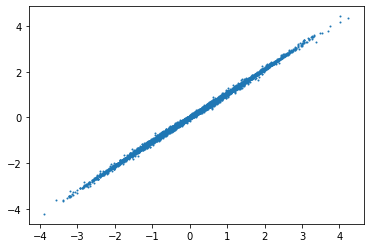

In [35]:
plt.scatter(origres.loc[overlap, 'SCORE'].apply(np.sign) * origres.loc[overlap, 'PVAL'].apply(np.log10)*-1,
            res.loc[overlap, 'BETA'].apply(np.sign) * res.loc[overlap, 'p.value'].apply(np.log10)*-1, s=1)

In [41]:
cmds = []
for p in phenotypes:
    for chrom in list(range(1,23)) + ['X']:
        cmd = 'tabix --csi -p vcf ../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=p, chrom=chrom)
        cmds.append(cmd)
        cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz    \
        --vcfFileIndex=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt \
        --chrom={chrom}       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE       \
        --is_Firth_beta=TRUE       \
        --pCutoffforFirth=0.0001       \
        --is_output_moreDetails=TRUE".format(p=p, chrom=chrom)
        cmds.append(cmd)
        
with open('submit_saige_outcome.sh', 'w') as F:
    F.write('\n'.join(cmds))

In [4]:
saige_res_outcome = {}
for p in phenotypes:
    pres = []
    country = p.split('_')[1]
    for chrom in list(range(1,23)) + ['X']:
        pres.append(pd.read_csv('../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt'.format(p=p, chrom=chrom), sep='\t'))
    saige_res_outcome[country] = pd.concat(pres, axis=0)
    saige_res_outcome[country].index = saige_res_outcome[country]['MarkerID']


In [72]:
for p in phenotypes:
    country = p.split('_')[1]
    saige_res_outcome[country]['N'] = saige_res_outcome[country]['N_case'] + saige_res_outcome[country]['N_ctrl']
    saige_res_outcome[country].to_csv('../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/SAIGE.merged.results.txt'.format(p=p, chrom=chrom), sep='\t', index=False)


In [16]:
saige_res_outcome = {}
for p in phenotypes:
    country = p.split('_')[1]
    saige_res_outcome[country] = pd.read_csv('../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/SAIGE.merged.results.txt'.format(p=p), sep='\t',)
    saige_res_outcome[country].index = saige_res_outcome[country]['MarkerID']

In [16]:
cols = ['MarkerID', 
       'AF_Allele2', 'MissingRate', 'BETA', 'p.value',
       'p.value.NA', 'Is.SPA', 'AF_case', 'AF_ctrl', 'N']
saige_res_outcome['NG'].loc[saige_res_outcome['NG']['CHR']==22, cols].sort_values(by='p.value').head(10)

,MarkerID,AF_Allele2,MissingRate,BETA,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N
MarkerID,,,,,,,,,,
"22:30619983[b37]G,A","22:30619983[b37]G,A",0.477723,0,-1.025720,1.126082e-07,1.590913e-07,True,0.346963,0.549107,303
"22:30658082[b37]T,C","22:30658082[b37]T,C",0.530033,0,-0.841763,3.096390e-06,3.748842e-06,True,0.405841,0.597832,303
"22:30209369[b37]T,C","22:30209369[b37]T,C",0.219472,0,-1.110460,5.999732e-06,6.719312e-06,True,0.121495,0.272959,303
"22:30618818[b37]G,C","22:30618818[b37]G,C",0.227640,0,-1.115100,7.290544e-06,8.024525e-06,True,0.132243,0.279719,303
"22:30195949[b37]G,C","22:30195949[b37]G,C",0.222112,0,-1.094370,7.650478e-06,8.537745e-06,True,0.125467,0.274872,303
"22:30167375[b37]T,C","22:30167375[b37]T,C",0.222525,0,-1.090810,7.880799e-06,8.787615e-06,True,0.125935,0.275255,303
"22:30173395[b37]G,C","22:30173395[b37]G,C",0.222525,0,-1.090810,7.880799e-06,8.787615e-06,True,0.125935,0.275255,303
"22:30205572[b37]C,T","22:30205572[b37]C,T",0.217739,0,-1.074170,1.277950e-05,1.424017e-05,True,0.123832,0.269005,303
"22:30614247[b37]C,A","22:30614247[b37]C,A",0.222690,0,-1.083670,1.351395e-05,1.474557e-05,True,0.130841,0.272832,303


In [18]:
saige_res_outcome['SL'].loc[saige_res_outcome['SL']['CHR']==22, cols].sort_values(by='p.value').head(20)

,MarkerID,AF_Allele2,MissingRate,BETA,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N
MarkerID,,,,,,,,,,
"22:32779924[b37]A,G","22:32779924[b37]A,G",0.250000,0,-1.79036,0.000001,0.000001,True,0.150000,0.434211,108
"22:32777852[b37]T,G","22:32777852[b37]T,G",0.222222,0,-1.57343,0.000017,0.000018,True,0.135714,0.381579,108
"22:32777569[b37]G,A","22:32777569[b37]G,A",0.226852,0,-1.56411,0.000022,0.000024,True,0.142857,0.381579,108
"22:32780557[b37]C,T","22:32780557[b37]C,T",0.332639,0,-1.39015,0.000025,0.000035,True,0.234643,0.513158,108
"22:32780664[b37]T,C","22:32780664[b37]T,C",0.332870,0,-1.38896,0.000026,0.000035,True,0.235000,0.513158,108
"22:32786629[b37]G,A","22:32786629[b37]G,A",0.226852,0,-1.51179,0.000032,0.000034,True,0.142857,0.381579,108
"22:43496495[b37]G,A","22:43496495[b37]G,A",0.560185,0,1.35502,0.000038,0.000052,True,0.678571,0.342105,108
"22:39590886[b37]C,T","22:39590886[b37]C,T",0.726852,0,-1.35292,0.000168,0.000218,True,0.650000,0.868421,108
"22:30983435[b37]A,G","22:30983435[b37]A,G",0.118287,0,-1.99973,0.000191,0.000213,True,0.068929,0.209211,108


## The NG lead chromosome 3 variant is filtered out from the SL analysis. Lets try to recover it

In [75]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=phenotypes[1], chrom=3)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [76]:
'3:61044[b37]T,C' in vars['ID'].values, '3:7330265[b37]A,G' in vars['ID'].values

(True, True)

In [77]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=phenotypes[1], chrom=17)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [78]:
'17:33192408[b37]C,G' in vars['ID'].values, '17:68745251[b37]C,G' in vars['ID'].values

(True, False)

In [79]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=phenotypes[1], chrom=7)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [80]:
'7:146356694[b37]T,A' in vars

False

In [81]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=phenotypes[0], chrom=7)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [82]:
'7:146356694[b37]T,A' in vars

False

In [55]:
cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz    \
        --vcfFileIndex=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/imputed_gwas/SAIGE.{chrom}.results.ExtraChr3NoMacThresh.txt \
        --chrom={chrom}       \
        --minMAF=0 \
        --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE       \
        --is_Firth_beta=TRUE       \
        --pCutoffforFirth=0.1       \
        --is_output_moreDetails=TRUE".format(p=phenotypes[1], chrom=3)
cmd

'Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R                --vcfFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.chr3.vcf.gz            --vcfFileIndex=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.chr3.vcf.gz.csi            --vcfField=DS           --AlleleOrder=ref-first         --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas/SAIGE.3.results.ExtraChr3NoMacThresh.txt         --chrom=3               --minMAF=0         --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/raw_gwas/SAIGE.rda         --varianceRatioFile=../../data/tmp/GWAS/outcome_H3covar_20220315

In [63]:
cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz    \
        --vcfFileIndex=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/imputed_gwas/SAIGE.{chrom}.results.ExtraChr3NoMacThresh.txt \
        --chrom={chrom}       \
        --minMAF=0 \
        --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE       \
        --is_Firth_beta=TRUE       \
        --pCutoffforFirth=0.1       \
        --is_output_moreDetails=TRUE".format(p=phenotypes[0], chrom=3)
cmd

'Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R                --vcfFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.chr3.vcf.gz            --vcfFileIndex=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.chr3.vcf.gz.csi            --vcfField=DS           --AlleleOrder=ref-first         --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/SAIGE.3.results.ExtraChr3NoMacThresh.txt         --chrom=3               --minMAF=0         --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/SAIGE.rda         --varianceRatioFile=../../data/tmp/GWAS/outcome_H3covar_20220315

## Run meta-analysis

In [4]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
OUTFILE ./meta_analysis.tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/SAIGE.merged.results.txt

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/SAIGE.merged.results.txt

ANALYZE 
"""

with open('meta_outcome.cmd', 'w') as F:
    F.write(cmd)
    
! ../../code/generic-metal/metal meta_outcome.cmd

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [5]:
! mv METAANALYSIS1.TBL /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.tsv

In [6]:
meta = pd.read_csv('/mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.tsv', sep='\t')
meta.head()

,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction
0,"4:134535101[b37]C,T",t,c,303.0,0.321,0.7484,+?
1,"8:81101490[b37]T,C",t,c,411.0,-0.153,0.8783,+-
2,"4:21809189[b37]A,G",a,g,411.0,-1.396,0.1628,--
3,"21:37413532[b37]A,C",a,c,411.0,0.369,0.7119,+-
4,"7:11568669[b37]G,C",c,g,411.0,0.246,0.8054,-+


In [13]:
pd.crosstab(meta['Weight'], meta['Direction'])

Direction,++,+-,+?,-+,--,-0,-?,?+,?-
Weight,,,,,,,,,
108.0,0,0,0,0,0,0,0,34641,35318
303.0,0,0,1962199,0,0,0,1959333,0,0
411.0,1170411,1172431,0,1170338,1171594,1,0,0,0


In [7]:
meta.sort_values(by='P-value', ascending=True).head(10)

,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction
4303471,"3:7330265[b37]A,G",a,g,303.0,6.040,1.543000e-09,+?
7832115,"22:30619983[b37]G,A",a,g,411.0,6.003,1.939000e-09,++
1442319,"3:7332556[b37]G,A",a,g,303.0,-5.596,2.193000e-08,-?
4433505,"3:7322569[b37]C,T",t,c,303.0,-5.513,3.524000e-08,-?
7569825,"3:7287290[b37]T,C",t,c,303.0,5.489,4.046000e-08,+?
6591843,"17:31757349[b37]C,T",t,c,303.0,-5.313,1.080000e-07,-?
7685150,"2:215526735[b37]G,A",a,g,303.0,5.042,4.601000e-07,+?
8669545,"5:8702372[b37]A,G",a,g,411.0,4.918,8.758000e-07,++
6459575,"7:70552362[b37]C,A",a,c,303.0,-4.912,9.006000e-07,-?
6298019,"3:7264050[b37]C,A",a,c,303.0,-4.870,1.119000e-06,-?


In [8]:
meta = meta.rename(columns={'P-value':'p.value'})

In [9]:
meta['CHR'] = meta['MarkerName'].apply(lambda x: x.split(':')[0]).replace({'X':'23'}).astype(int)
meta['POS'] = meta['MarkerName'].apply(lambda x: x.split(':')[1].split('[')[0]).astype(int)

In [10]:
meta = meta.sort_values(by=['CHR', 'POS'], ascending=True)

In [11]:
meta['CHR'] = meta['CHR'].astype(str).replace({'23':'X'})

In [12]:
meta.to_csv('/mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis_Cleaned.tsv', sep='\t', index=False)

In [17]:
meta = pd.read_csv('/mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis_Cleaned.tsv', sep='\t')

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
saige_res_outcome['Meta'] = meta

In [19]:
saige_res_outcome['Meta'].index = saige_res_outcome['Meta']['MarkerName']

In [73]:
title_map = {'NG':'Nigeria - Outcome', 'SL':'Sierra Leone - Outcome', 'Meta':'Meta-analysis - Outcome'}

In [74]:
full_phenotypes = ['NG', 'SL', 'Meta']

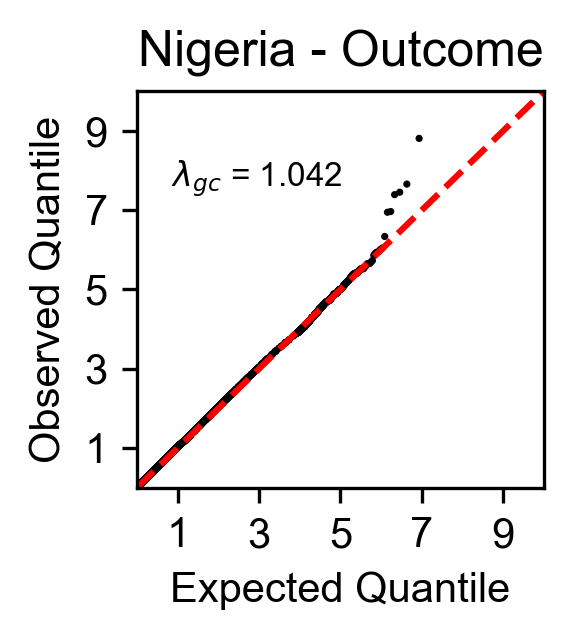

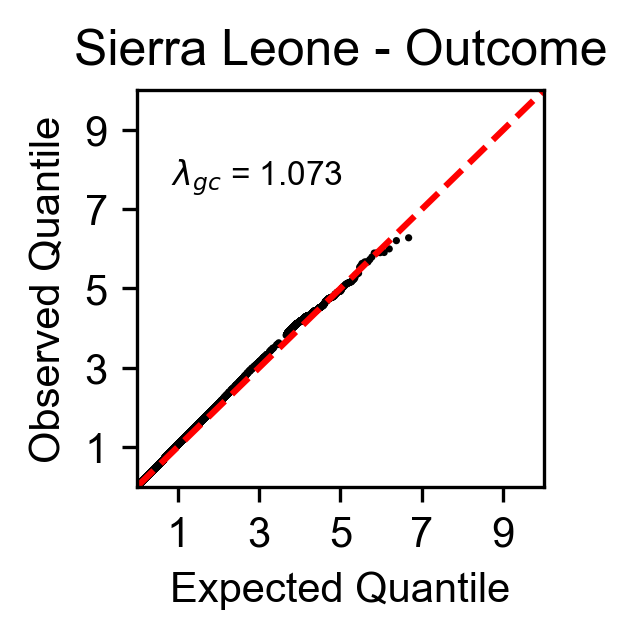

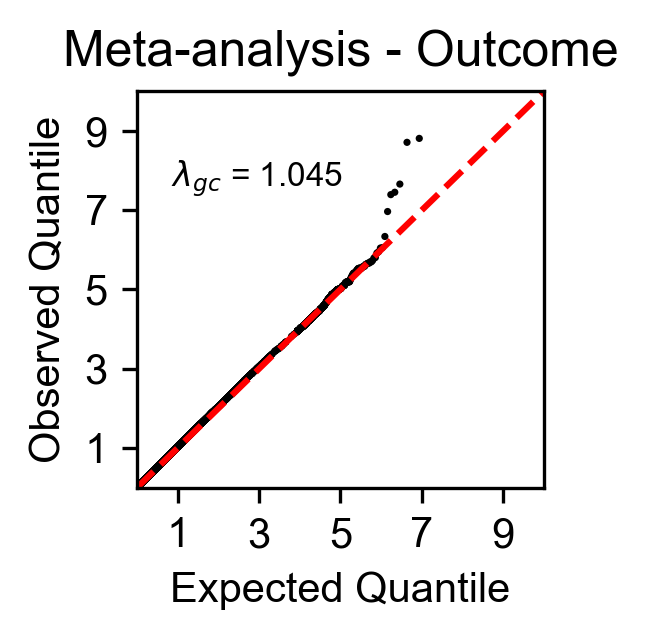

In [14]:
for p in full_phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(1.75,1.75), dpi=300)
    P = saige_res_outcome[p]['p.value'].dropna().values.reshape(-1)
    ax = qqplot(P, num_top_points=1000, numsample=50000, fill_dens=0.2, title=title_map[p],ax=ax, dot_size=3, rasterized=True)
    
    if p == 'NG':
        ax.set_xticks([1,3,5,7,9])
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])
    else:
        ax.set_xticks([1,3,5,7,9])
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
        ax.set_xlim([0, 10])
        
    ax.set_xlabel('Expected Quantile')
    ax.set_ylabel('Observed Quantile')
    
    gc = np.median(chi2.ppf(1-saige_res_outcome[p]['p.value'].dropna(), df=1)) / chi2.ppf(.5, df=1)

    
    plt.figtext(.19, .7, '$\lambda_{gc}$ = %.3f' % gc, fontsize=8)

    
    outbase = "../../figures/SAIGE_Outcome" + p + "_qqplot_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

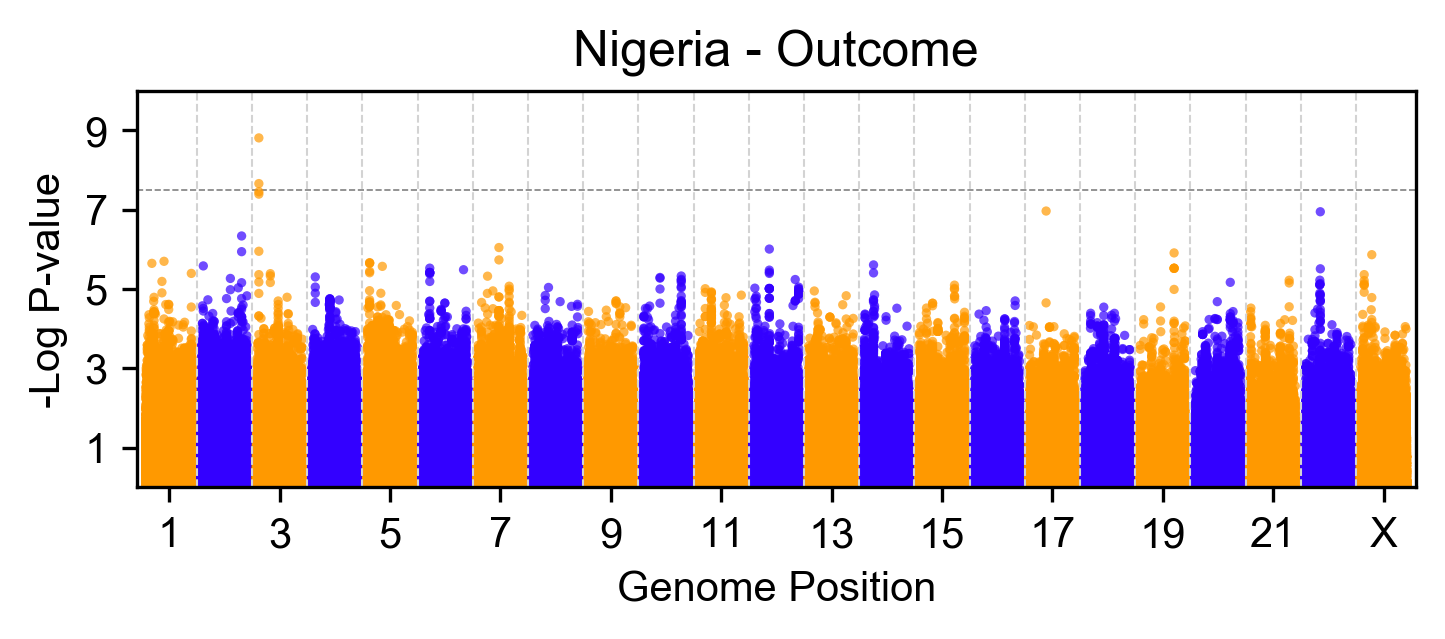

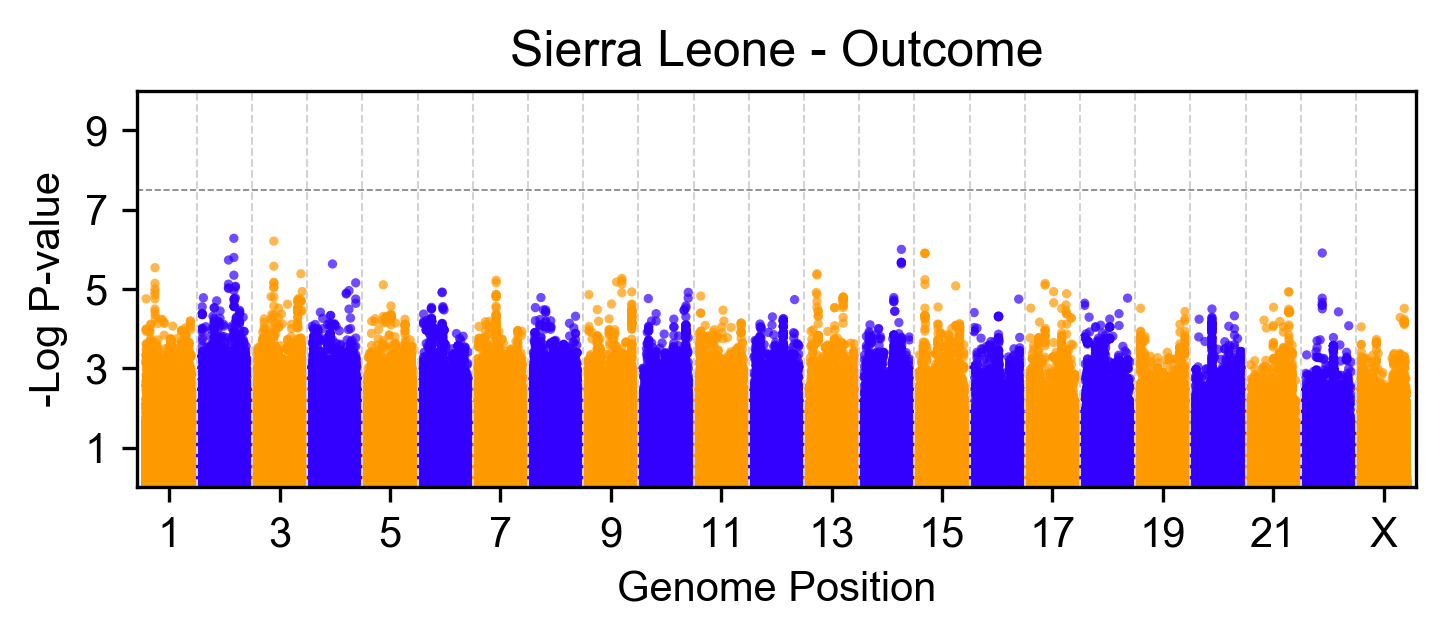

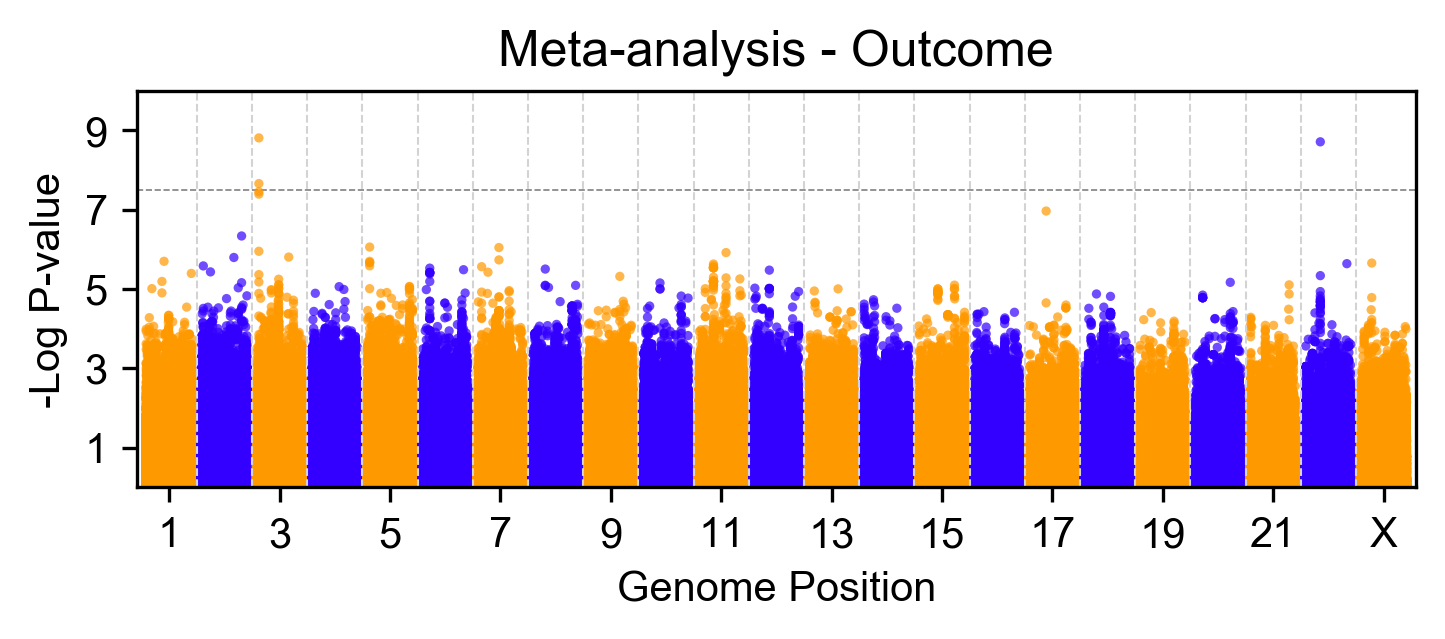

In [16]:
chroms = [str(x) for x in range(1,23)]+['X'] 
chrlist = []
for i in range(len(chroms)):
    if (i % 2) == 0:
        chrlist.append(chroms[i])
    else:
        chrlist.append('')

xlabel='CHR'

for p in full_phenotypes:
    (fig,ax) = plt.subplots(1,1, figsize=(5.5,1.75), dpi=300)
    ind = ~saige_res_outcome[p]['p.value'].isnull()
    P = saige_res_outcome[p].loc[ind,'p.value'].values
    logP = -1*np.log10(P)
    bp = saige_res_outcome[p].loc[ind,'POS'].values
    chrs = saige_res_outcome[p].loc[ind, 'CHR'].astype(str).values
    manhattan_fixwidth(bp, chrs, P=None, minusLogP=logP, ax=ax, colors=['#ff9900', '#3300ff'],
             chrlist=chroms, chrlabels=chrlist, plotheight=None, cut=0, dotsize=5, spacer=.2,
             xlabel='', title='', only_altticks=True, rasterized=True)
    xlim = ax.get_xlim()
    ax.hlines(y=-1*np.log10(3.24e-8), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='gray', lw=0.4, zorder=-10)

    if p == 'NG':
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    else:
        ax.set_yticks([1,3,5,7,9])
        ax.set_ylim([0, 10])
    
    ax.set_xlabel('Genome Position')
    ax.set_title(title_map[p])
    
    
    outbase = "../../figures/SAIGE_OUTCOME_" + p + "_manhattan_imp"
    plt.savefig(outbase + ".png", bbox_inches = 'tight')
    plt.savefig(outbase + ".pdf", bbox_inches = 'tight')

In [18]:
saige_res_outcome['NG'].sort_values(by='p.value').iloc[:10, :20]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom
MarkerID,,,,,,,,,,,,,,,,,,,,
"3:7330265[b37]A,G",3,7330265,"3:7330265[b37]A,G",A,G,28.65,0.047277,0,2.732230,0.460986,14.7719,6.31297,1.543296e-09,4.122315e-09,True,0.117757,0.008801,107,196,1
"3:7332556[b37]G,A",3,7332556,"3:7332556[b37]G,A",G,A,24.60,0.040594,0,2.647130,0.483530,12.6113,5.25201,2.192694e-08,3.734924e-08,True,0.099766,0.008291,107,196,0
"3:7322569[b37]C,T",3,7322569,"3:7322569[b37]C,T",C,T,21.70,0.035809,0,2.870830,0.532627,11.5735,4.60753,3.523985e-08,6.977914e-08,True,0.089486,0.006505,107,196,0
"3:7287290[b37]T,C",3,7287290,"3:7287290[b37]T,C",T,C,20.20,0.033333,0,2.884190,0.537585,10.9168,4.01853,4.045593e-08,5.157894e-08,True,0.083645,0.005867,107,196,0
"17:31757349[b37]C,T",17,31757349,"17:31757349[b37]C,T",C,T,32.35,0.053383,0,2.133400,0.411459,13.3917,6.53745,1.080284e-07,1.626752e-07,True,0.116121,0.019133,107,196,2
"22:30619983[b37]G,A",22,30619983,"22:30619983[b37]G,A",G,A,289.50,0.477723,0,-1.025720,0.198122,-28.6839,29.94530,1.126082e-07,1.590913e-07,True,0.346963,0.549107,107,196,12
"2:215526735[b37]G,A",2,215526735,"2:215526735[b37]G,A",G,A,418.85,0.691172,0,-0.929927,0.189472,-26.9473,29.04290,4.600820e-07,5.724552e-07,True,0.565421,0.759821,107,196,33
"7:70552362[b37]C,A",7,70552362,"7:70552362[b37]C,A",C,A,21.90,0.036139,0,2.464300,0.516132,10.2346,4.81998,9.005874e-07,3.135599e-06,True,0.088551,0.007526,107,196,1
"12:44394175[b37]C,T",12,44394175,"12:44394175[b37]C,T",C,T,54.00,0.089109,0,1.422790,0.299119,16.1918,11.02470,9.844290e-07,1.079574e-06,True,0.163551,0.048469,107,196,2


In [19]:
saige_res_outcome['SL'].sort_values(by='p.value').iloc[:10, :20]

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,Tstat,var,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom
MarkerID,,,,,,,,,,,,,,,,,,,,
"2:172990449[b37]A,T",2,172990449,"2:172990449[b37]A,T",A,T,20.50,0.094907,0,-2.86894,0.587707,-8.79420,3.35604,5.261636e-07,0.000002,True,0.035714,0.203947,70,38,0
"3:73438059[b37]G,A",3,73438059,"3:73438059[b37]G,A",G,A,77.00,0.356481,0,-1.65350,0.341007,-15.42430,10.07450,6.208098e-07,0.000001,True,0.242857,0.565789,70,38,4
"14:89776334[b37]G,A",14,89776334,"14:89776334[b37]G,A",G,A,24.15,0.111806,0,-2.56937,0.540576,-9.32921,3.90443,1.001950e-06,0.000002,True,0.043929,0.236842,70,38,0
"22:32779924[b37]A,G",22,32779924,"22:32779924[b37]A,G",A,G,54.00,0.250000,0,-1.79036,0.380075,-13.19130,7.47386,1.235342e-06,0.000001,True,0.150000,0.434211,70,38,2
"15:34269975[b37]T,C",15,34269975,"15:34269975[b37]T,C",T,C,33.25,0.153935,0,-2.11132,0.448382,-11.16030,5.58326,1.246118e-06,0.000002,True,0.061429,0.324342,70,38,0
"15:34271648[b37]T,C",15,34271648,"15:34271648[b37]T,C",T,C,33.35,0.154398,0,-2.10908,0.448148,-11.17280,5.61788,1.261786e-06,0.000002,True,0.061786,0.325000,70,38,0
"15:34268336[b37]G,A",15,34268336,"15:34268336[b37]G,A",G,A,33.35,0.154398,0,-2.10782,0.448111,-11.16360,5.61429,1.276941e-06,0.000002,True,0.061786,0.325000,70,38,0
"2:172987675[b37]G,A",2,172987675,"2:172987675[b37]G,A",G,A,44.70,0.206944,0,-2.04201,0.438486,-11.39040,5.72824,1.604641e-06,0.000002,True,0.134286,0.340789,70,38,2
"2:141968307[b37]T,C",2,141968307,"2:141968307[b37]T,C",T,C,129.00,0.597222,0,-1.67636,0.362345,-15.38140,10.88900,1.860207e-06,0.000003,True,0.494286,0.786842,70,38,18


In [73]:
for snp in ['3:7330265[b37]A,G', '22:30619983[b37]G,A']:
    for p in ['NG', 'SL', 'Meta']:
        if (snp not in saige_res_outcome[p].index):
            continue
    
    
        print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
        print('P %.4e' % saige_res_outcome[p].loc[snp, 'p.value'])

        if (p != 'Meta'):
            print('OR %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA']), 4))
            print('Lower CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] - 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
            print('Upper CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] + 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
            print('AF %.3f' % np.round(saige_res_outcome[p].loc[snp, 'AF_Allele2']*100, 2))
    
        print('\n\n')

Pheno: NG. SNP: 3:7330265[b37]A,G. ID rs9870087
P 1.5433e-09
OR 15.367
Lower CI 6.226
Upper CI 37.931
AF 4.730



Pheno: Meta. SNP: 3:7330265[b37]A,G. ID rs9870087
P 1.5430e-09



Pheno: NG. SNP: 22:30619983[b37]G,A. ID rs73404538
P 1.1261e-07
OR 0.358
Lower CI 0.243
Upper CI 0.529
AF 47.770



Pheno: SL. SNP: 22:30619983[b37]G,A. ID rs73404538
P 4.7376e-03
OR 0.389
Lower CI 0.191
Upper CI 0.794
AF 30.810



Pheno: Meta. SNP: 22:30619983[b37]G,A. ID rs73404538
P 1.9390e-09





In [20]:
saige_res_outcome['NG'].loc['3:7330265[b37]A,G', :]

CHR                            3
POS                      7330265
MarkerID       3:7330265[b37]A,G
Allele1                        A
Allele2                        G
AC_Allele2                 28.65
AF_Allele2             0.0472772
MissingRate                    0
BETA                     2.73223
SE                      0.460986
Tstat                    14.7719
var                      6.31297
p.value               1.5433e-09
p.value.NA           4.12231e-09
Is.SPA                      True
AF_case                 0.117757
AF_ctrl               0.00880102
N_case                       107
N_ctrl                       196
N_case_hom                     1
N_case_het                    24
N_ctrl_hom                     1
N_ctrl_het                     1
Name: 3:7330265[b37]A,G, dtype: object

In [ ]:
3:7330265

In [80]:
saige_outcome_sl_chr3 = pd.read_csv('/mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas/SAIGE.3.results.ExtraChr3NoMacThresh.txt', sep='\t')
saige_outcome_sl_chr3.index = saige_outcome_sl_chr3['MarkerID']
saige_outcome_sl_chr3.loc['3:7330265[b37]A,G', :]

CHR                            3
POS                      7330265
MarkerID       3:7330265[b37]A,G
Allele1                        A
Allele2                        G
AC_Allele2                 10.85
AF_Allele2             0.0502315
MissingRate                    0
BETA                   -0.442979
SE                      0.743551
Tstat                  -0.801239
var                      1.80875
p.value                 0.551334
p.value.NA              0.551334
Is.SPA                     False
AF_case                0.0417857
AF_ctrl                0.0657895
N_case                        70
N_ctrl                        38
N_case_hom                     0
N_case_het                     6
N_ctrl_hom                     0
N_ctrl_het                     5
N                            108
Name: 3:7330265[b37]A,G, dtype: object

In [23]:
saige_res_outcome['SL'].loc['22:30619983[b37]G,A', :]

CHR                             22
POS                       30619983
MarkerID       22:30619983[b37]G,A
Allele1                          G
Allele2                          A
AC_Allele2                   66.55
AF_Allele2                0.308102
MissingRate                      0
BETA                     -0.944466
SE                        0.364038
Tstat                     -8.32936
var                        8.81912
p.value                 0.00473763
p.value.NA              0.00503507
Is.SPA                        True
AF_case                   0.256786
AF_ctrl                   0.402632
N_case                          70
N_ctrl                          38
N_case_hom                       3
N_case_het                      30
N_ctrl_hom                       8
N_ctrl_het                      15
Name: 22:30619983[b37]G,A, dtype: object

In [24]:
saige_res_outcome['NG'].loc['22:30619983[b37]G,A', :]

CHR                             22
POS                       30619983
MarkerID       22:30619983[b37]G,A
Allele1                          G
Allele2                          A
AC_Allele2                   289.5
AF_Allele2                0.477723
MissingRate                      0
BETA                      -1.02572
SE                        0.198122
Tstat                     -28.6839
var                        29.9453
p.value                1.12608e-07
p.value.NA             1.59091e-07
Is.SPA                        True
AF_case                   0.346963
AF_ctrl                   0.549107
N_case                         107
N_ctrl                         196
N_case_hom                      12
N_case_het                      50
N_ctrl_hom                      54
N_ctrl_het                     109
Name: 22:30619983[b37]G,A, dtype: object

In [79]:
snp = '3:7330265[b37]A,G'
for p in ['NG', 'SL', 'Meta']:
    if (snp not in saige_res_outcome[p].index):
        continue
    
    
    print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
    print('P %.4e' % saige_res_outcome[p].loc[snp, 'p.value'])

    if (p != 'Meta'):
        print('OR %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA']), 4))
        print('Lower CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] - 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
        print('Upper CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] + 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
    
    print('\n\n')

Pheno: NG. SNP: 3:7330265[b37]A,G. ID rs9870087
P 1.5433e-09
OR 15.367
Lower CI 6.226
Upper CI 37.931



Pheno: Meta. SNP: 3:7330265[b37]A,G. ID rs9870087
P 1.5430e-09





In [81]:
snp = '3:7330265[b37]A,G'
p = 'MergeEpoch_SL_Died_vs_Survived'
    
print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
print('P %.4e' % saige_outcome_sl_chr3.loc[snp, 'p.value'])

if (p != 'Meta'):
    print('OR %.3f' % np.round(np.exp(saige_outcome_sl_chr3.loc[snp, 'BETA']), 4))
    print('Lower CI %.3f' % np.round(np.exp(saige_outcome_sl_chr3.loc[snp, 'BETA'] - 1.96*saige_outcome_sl_chr3.loc[snp, 'SE']), 4))
    print('Upper CI %.3f' % np.round(np.exp(saige_outcome_sl_chr3.loc[snp, 'BETA'] + 1.96*saige_outcome_sl_chr3.loc[snp, 'SE']), 4))

Pheno: MergeEpoch_SL_Died_vs_Survived. SNP: 3:7330265[b37]A,G. ID rs9870087
P 5.5133e-01
OR 0.642
Lower CI 0.149
Upper CI 2.758


In [82]:
saige_outcome_sl_chr3.loc[snp, :]

CHR                            3
POS                      7330265
MarkerID       3:7330265[b37]A,G
Allele1                        A
Allele2                        G
AC_Allele2                 10.85
AF_Allele2             0.0502315
MissingRate                    0
BETA                   -0.442979
SE                      0.743551
Tstat                  -0.801239
var                      1.80875
p.value                 0.551334
p.value.NA              0.551334
Is.SPA                     False
AF_case                0.0417857
AF_ctrl                0.0657895
N_case                        70
N_ctrl                        38
N_case_hom                     0
N_case_het                     6
N_ctrl_hom                     0
N_ctrl_het                     5
N                            108
Name: 3:7330265[b37]A,G, dtype: object

In [80]:
snp = '22:30619983[b37]G,A'
for p in ['NG', 'SL', 'Meta']:
    if (snp not in saige_res_outcome[p].index):
        continue
    
    
    print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
    print('P %.4e' % saige_res_outcome[p].loc[snp, 'p.value'])

    if (p != 'Meta'):
        print('OR %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA']), 4))
        print('Lower CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] - 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
        print('Upper CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] + 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
    
    print('\n\n')

Pheno: NG. SNP: 22:30619983[b37]G,A. ID rs73404538
P 1.1261e-07
OR 0.358
Lower CI 0.243
Upper CI 0.529



Pheno: SL. SNP: 22:30619983[b37]G,A. ID rs73404538
P 4.7376e-03
OR 0.389
Lower CI 0.191
Upper CI 0.794



Pheno: Meta. SNP: 22:30619983[b37]G,A. ID rs73404538
P 1.9390e-09





In [81]:
saige_res['SL'].loc['22:30619983[b37]G,A', :]

CHR                             22
POS                       30619983
MarkerID       22:30619983[b37]G,A
Allele1                          G
Allele2                          A
AC_Allele2                   659.6
AF_Allele2                0.358089
MissingRate                      0
BETA                     -0.346558
SE                        0.196556
Tstat                     -12.3098
var                        35.5201
p.value                  0.0389376
p.value.NA               0.0388809
Is.SPA                        True
AF_case                   0.301434
AF_ctrl                    0.36674
N_case                         122
N_ctrl                         799
N_case_hom                      13
N_case_het                      48
N_ctrl_hom                     106
N_ctrl_het                     375
N                              921
Name: 22:30619983[b37]G,A, dtype: object

In [82]:
np.exp(-0.346558)

0.7071178052651708

In [83]:
saige_res['Meta'].loc['22:30619983[b37]G,A', :]

MarkerName    22:30619983[b37]G,A
Allele1                         a
Allele2                         g
Weight                       2519
Zscore                      2.311
p.value                   0.02082
Direction                      ++
CHR                            22
POS                      30619983
Name: 22:30619983[b37]G,A, dtype: object

In [172]:
for snp in ['7:146356694[b37]T,A', '17:33192408[b37]C,G', '17:68745251[b37]C,G']:
    for p in ['NG', 'SL', 'Meta']:
        if (snp not in saige_res_outcome[p].index):
            print(snp + ' missing from ' + p)
            continue
    
    
        print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
        print('P %.4e' % saige_res_outcome[p].loc[snp, 'p.value'])

        if (p != 'Meta'):
            print('OR %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA']), 4))
            print('Lower CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] - 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
            print('Upper CI %.3f' % np.round(np.exp(saige_res_outcome[p].loc[snp, 'BETA'] + 1.96*saige_res_outcome[p].loc[snp, 'SE']), 4))
    
        print('\n\n')

7:146356694[b37]T,A missing from NG
7:146356694[b37]T,A missing from SL
7:146356694[b37]T,A missing from Meta
Pheno: NG. SNP: 17:33192408[b37]C,G. ID rs143130878
P 7.5013e-01
OR 1.160
Lower CI 0.466
Upper CI 2.889



17:33192408[b37]C,G missing from SL
Pheno: Meta. SNP: 17:33192408[b37]C,G. ID rs143130878
P 7.5010e-01



Pheno: NG. SNP: 17:68745251[b37]C,G. ID rs73397758
P 1.3751e-01
OR 0.558
Lower CI 0.258
Upper CI 1.205



17:68745251[b37]C,G missing from SL
Pheno: Meta. SNP: 17:68745251[b37]C,G. ID rs73397758
P 1.3750e-01





In [25]:
saige_res_outcome.keys()

dict_keys(['NG', 'SL'])

## Run meta-analysis separate for chromosome 3

In [68]:
fn = '/mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/SAIGE.3.results.ExtraChr3NoMacThresh.txt'
dat = pd.read_csv(fn, sep='\t')
dat['N'] = dat['N_case'] + dat['N_ctrl']
dat.to_csv(fn, sep='\t', index=False)

In [69]:
fn = '/mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas/SAIGE.3.results.ExtraChr3NoMacThresh.txt'
dat = pd.read_csv(fn, sep='\t')
dat['N'] = dat['N_case'] + dat['N_ctrl']
dat.to_csv(fn, sep='\t', index=False)

In [70]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
OUTFILE ./meta_analysis.tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/SAIGE.3.results.ExtraChr3NoMacThresh.txt

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas/SAIGE.3.results.ExtraChr3NoMacThresh.txt

ANALYZE 
"""

with open('meta_outcome_chr3.cmd', 'w') as F:
    F.write(cmd)
    
! ../../code/generic-metal/metal meta_outcome_chr3.cmd

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [71]:
! mv METAANALYSIS1.TBL /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.ExtraChr3NoMacThresh.tsv

In [73]:
meta_chr3 = pd.read_csv('/mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.ExtraChr3NoMacThresh.tsv', sep='\t')

In [75]:
meta_chr3.index = meta_chr3['MarkerName']

In [76]:
snp = '3:7330265[b37]A,G'
meta_chr3.loc[snp, :]

MarkerName    3:7330265[b37]A,G
Allele1                       a
Allele2                       g
Weight                      411
Zscore                     4.88
P-value               1.058e-06
Direction                    +-
Name: 3:7330265[b37]A,G, dtype: object

In [78]:
saige_res_outcome['NG'].loc[snp, :]

CHR                            3
POS                      7330265
MarkerID       3:7330265[b37]A,G
Allele1                        A
Allele2                        G
AC_Allele2                 28.65
AF_Allele2             0.0472772
MissingRate                    0
BETA                     2.73223
SE                      0.460986
Tstat                    14.7719
var                      6.31297
p.value               1.5433e-09
p.value.NA           4.12231e-09
Is.SPA                      True
AF_case                 0.117757
AF_ctrl               0.00880102
N_case                       107
N_ctrl                       196
N_case_hom                     1
N_case_het                    24
N_ctrl_hom                     1
N_ctrl_het                     1
N                            303
Name: 3:7330265[b37]A,G, dtype: object

In [79]:
saige_outcome_sl_chr3.loc[snp, :]

CHR                            3
POS                      7330265
MarkerID       3:7330265[b37]A,G
Allele1                        A
Allele2                        G
AC_Allele2                    57
AF_Allele2             0.0309446
MissingRate                    0
BETA                    0.324837
SE                      0.444494
Tstat                    1.64412
var                      5.06137
p.value                 0.464901
p.value.NA              0.464901
Is.SPA                     False
AF_case                0.0485656
AF_ctrl                0.0282541
N_case                       122
N_ctrl                       799
N_case_hom                     0
N_case_het                    12
N_ctrl_hom                     1
N_ctrl_het                    42
Name: 3:7330265[b37]A,G, dtype: object

## Run outcome association for susceptibility lead variants

In [165]:
import os 
tmpdir = '../../data/tmp/'
resdir = os.path.join(tmpdir, 'GWAS', 'outcome_H3covar_20220315')
impbase = '../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr{c}'

chroms = [7, 17]
praw_adats = []
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    if not os.path.exists(pdir_impdata): os.mkdir(pdir_impdata)
    pdir_imp_dosage_data = os.path.join(pdir, 'imputed_dosage_data')
    sampfn = os.path.join(pdir, 'samples.txt')
    samps = pd.read_csv(sampfn, sep='\t', header=None)
    sampfn_fix = sampfn.replace('.txt', '_noFID.txt')
    samps[1].to_csv(sampfn_fix, index=False, header=False)
    for c in chroms:
        inv = impbase.format(c=c)
        outfn = os.path.join(pdir_impdata, inv.split('/')[-1].split('chr')[0] +'{p}.Mac_3.NoFilterForCrossCheck.chr{c}'.format(p=p, c=c))
        filt_cmd = 'plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile {inv} --keep {samples} --keep-allele-order --out {out} --mac 3 --set-all-var-ids @:#[b37]\$r,\$a'.format(inv=inv, samples=sampfn_fix, out=outfn)
        print(filt_cmd)
        #!{filt_cmd}
        print('\n')
        cmd = 'tabix --csi -p vcf {outfn}.vcf.gz'.format(outfn=outfn)
        print(cmd)
        !{cmd}
        print('--------------------------\n\n\n\n\n\n\n')


plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile ../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr7 --keep ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/samples_noFID.txt --keep-allele-order --out ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.Mac_3.NoFilterForCrossCheck.chr7 --mac 3 --set-all-var-ids @:#[b37]\$r,\$a


tabix --csi -p vcf ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.Mac_3.NoFilterForCrossCheck.chr7.vcf.gz
--------------------------







plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile ../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr17 --keep ../../data/tmp/GWAS/outcome_H3covar_20220

In [87]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.Mac_3.NoFilterForCrossCheck.chr{chrom}.vcf.gz'.format(p=phenotypes[0], chrom=7)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [88]:
'7:146356694[b37]T,A' in vars['ID'].values

True

In [90]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.Mac_3.NoFilterForCrossCheck.chr{chrom}.vcf.gz'.format(p=phenotypes[1], chrom=7)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [91]:
'7:146356694[b37]T,A' in vars['ID'].values

True

In [92]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.Mac_3.NoFilterForCrossCheck.chr{chrom}.vcf.gz'.format(p=phenotypes[1], chrom=17)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [93]:
'17:33192408[b37]C,G' in vars['ID'].values, '17:68745251[b37]C,G' in vars['ID'].values

(True, True)

In [133]:
fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.Mac_3.NoFilterForCrossCheck.chr{chrom}.vcf.gz'.format(p=phenotypes[0], chrom=17)
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [136]:
fn

'../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.Mac_3.NoFilterForCrossCheck.chr17.vcf.gz'

In [134]:
'17:33192408[b37]C,G' in vars['ID'].values, '17:68745251[b37]C,G' in vars['ID'].values

(True, True)

In [135]:
fn

'../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.Mac_3.NoFilterForCrossCheck.chr17.vcf.gz'

In [157]:
dat = pd.read_csv('../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.Mac_3.NoFilterForCrossCheck.chr{chrom}.vcf.gz'.format(p=phenotypes[1], chrom=17), sep='\t', skiprows=21)

In [158]:
dat = dat.loc[dat['ID']=='17:68745251[b37]C,G',:]

In [159]:
dat = dat.iloc[:, 9:].T.iloc[:, 0]

In [161]:
dat.apply(lambda x: x.split(':')[1]).astype(float).sum()

17.25

In [167]:
for p in phenotypes:
    for chrom in [7, 17]:
        cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
            --vcfFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.Mac_3.NoFilterForCrossCheck.chr{chrom}.vcf.gz    \
            --vcfFileIndex=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.Mac_3.NoFilterForCrossCheck.chr{chrom}.vcf.gz.csi    \
            --vcfField=DS   \
            --AlleleOrder=ref-first \
            --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/imputed_gwas/SAIGE.{chrom}.results.ExtraChr{chrom}NoMacThresh.txt \
            --chrom={chrom}       \
            --minMAF=0 \
            --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.rda \
            --varianceRatioFile=../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
            --LOCO=TRUE       \
            --is_Firth_beta=TRUE       \
            --pCutoffforFirth=0.1       \
            --is_output_moreDetails=TRUE".format(p=p, chrom=chrom)
        print(cmd)
        print('\n\n')

Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R                    --vcfFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.Mac_3.NoFilterForCrossCheck.chr7.vcf.gz                --vcfFileIndex=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_Died_vs_Survived.Mac_3.NoFilterForCrossCheck.chr7.vcf.gz.csi                --vcfField=DS               --AlleleOrder=ref-first             --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/SAIGE.7.results.ExtraChr7NoMacThresh.txt             --chrom=7                   --minMAF=0             --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/SAIGE.rda             --varianceRatioFile=../../dat

In [174]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
OUTFILE ./meta_analysis.tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/SAIGE.7.results.ExtraChr7NoMacThresh.txt

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas/SAIGE.7.results.ExtraChr7NoMacThresh.txt

ANALYZE 
"""

with open('meta_outcome_chr7.cmd', 'w') as F:
    F.write(cmd)
    
! ../../code/generic-metal/metal meta_outcome_chr7.cmd

! mv METAANALYSIS1.TBL /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.ExtraChr7NoMacThresh.tsv

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [175]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
OUTFILE ./meta_analysis.tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/imputed_gwas/SAIGE.17.results.ExtraChr17NoMacThresh.txt

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/imputed_gwas/SAIGE.17.results.ExtraChr17NoMacThresh.txt

ANALYZE 
"""

with open('meta_outcome_chr17.cmd', 'w') as F:
    F.write(cmd)
    
! ../../code/generic-metal/metal meta_outcome_chr17.cmd
! mv METAANALYSIS1.TBL /mnt/disks/gwas/data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.ExtraChr17NoMacThresh.tsv

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [176]:
susceptibility_lookup_res = {}

for p in phenotypes:
    tocheck = ['7:146356694[b37]T,A', '17:33192408[b37]C,G', '17:68745251[b37]C,G']
    country = p.split('_')[1]
    susceptibility_lookup_res[country] = []
    for chrom in [7, 17]:
        fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/{p}/results/imputed_gwas/SAIGE.{chrom}.results.ExtraChr{chrom}NoMacThresh.txt'.format(p=p, chrom=chrom)
        dat = pd.read_csv(fn, sep='\t')
        dat.index = dat['MarkerID']
        susceptibility_lookup_res[country].append(dat.loc[dat['MarkerID'].isin(tocheck), :])
        
    susceptibility_lookup_res[country] = pd.concat(susceptibility_lookup_res[country], axis=0)
        

In [177]:
p = 'Meta'
tocheck = ['7:146356694[b37]T,A', '17:33192408[b37]C,G', '17:68745251[b37]C,G']
susceptibility_lookup_res[p] = []
for chrom in [7, 17]:
    fn = '../../data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.ExtraChr{c}NoMacThresh.tsv'.format(c=chrom)
    dat = pd.read_csv(fn, sep='\t')
    dat.index = dat['MarkerName']
    susceptibility_lookup_res[p].append(dat.loc[dat['MarkerName'].isin(tocheck), :])
        
susceptibility_lookup_res[p] = pd.concat(susceptibility_lookup_res[p], axis=0)
susceptibility_lookup_res['Meta'] = susceptibility_lookup_res['Meta'].rename(columns={'P-value':'p.value'})        

In [178]:
susceptibility_lookup_res['Meta']

,MarkerName,Allele1,Allele2,Weight,Zscore,p.value,Direction
MarkerName,,,,,,,
"7:146356694[b37]T,A","7:146356694[b37]T,A",a,t,2.0,-1.334,0.1823,--
"17:68745251[b37]C,G","17:68745251[b37]C,G",c,g,2.0,1.158,0.2468,-+
"17:33192408[b37]C,G","17:33192408[b37]C,G",c,g,2.0,-0.189,0.8499,+-


In [179]:
for snp in ['7:146356694[b37]T,A', '17:33192408[b37]C,G', '17:68745251[b37]C,G']:
    for p in ['NG', 'SL', 'Meta']:
        if (snp not in susceptibility_lookup_res[p].index):
            continue
    
    
        print('Pheno: %s. SNP: %s. ID %s' % (p, snp, var2id[snp]))
        print('P %.4e' % susceptibility_lookup_res[p].loc[snp, 'p.value'])

        if (p != 'Meta'):
            print('OR %.3f' % np.round(np.exp(susceptibility_lookup_res[p].loc[snp, 'BETA']), 4))
            print('Lower CI %.3f' % np.round(np.exp(susceptibility_lookup_res[p].loc[snp, 'BETA'] - 1.96*susceptibility_lookup_res[p].loc[snp, 'SE']), 4))
            print('Upper CI %.3f' % np.round(np.exp(susceptibility_lookup_res[p].loc[snp, 'BETA'] + 1.96*susceptibility_lookup_res[p].loc[snp, 'SE']), 4))
    
        print('\n\n')

Pheno: NG. SNP: 7:146356694[b37]T,A. ID rs114992845
P 8.1519e-01
OR 1.137
Lower CI 0.387
Upper CI 3.343



Pheno: SL. SNP: 7:146356694[b37]T,A. ID rs114992845
P 9.8450e-02
OR 8.244
Lower CI 0.335
Upper CI 203.058



Pheno: Meta. SNP: 7:146356694[b37]T,A. ID rs114992845
P 1.8230e-01



Pheno: NG. SNP: 17:33192408[b37]C,G. ID rs143130878
P 7.5013e-01
OR 1.160
Lower CI 0.466
Upper CI 2.889



Pheno: SL. SNP: 17:33192408[b37]C,G. ID rs143130878
P 5.5780e-01
OR 0.698
Lower CI 0.210
Upper CI 2.324



Pheno: Meta. SNP: 17:33192408[b37]C,G. ID rs143130878
P 8.4990e-01



Pheno: NG. SNP: 17:68745251[b37]C,G. ID rs73397758
P 1.3751e-01
OR 0.558
Lower CI 0.258
Upper CI 1.205



Pheno: SL. SNP: 17:68745251[b37]C,G. ID rs73397758
P 1.7898e-03
OR 22.561
Lower CI 2.772
Upper CI 183.633



Pheno: Meta. SNP: 17:68745251[b37]C,G. ID rs73397758
P 2.4680e-01





In [180]:
susceptibility_lookup_res.keys()

dict_keys(['NG', 'SL', 'Meta'])

## Outcome with age

In [2]:
phenotypes = ['MergeEpoch_NG_Died_vs_Survived',
             'MergeEpoch_SL_Died_vs_Survived']

In [3]:
for p in phenotypes:
    origbase = '../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2'.format(p=p)
    newbase = origbase + '.FixSexChr'
    for ext in ['bed', 'bim', 'fam']:
        cmd = 'cp {o}.{ext} {n}.{ext}'.format(o=origbase, ext=ext, n=newbase)
        print(cmd)
        !{cmd}
    
    bim = pd.read_csv('{n}.bim'.format(n=newbase), sep='\t', header=None)
    bim[0] = bim[0].replace({'X':23, 'Y':24})
    bim.to_csv('{n}.bim'.format(n=newbase), sep='\t', header=False, index=False)

cp ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim
cp ../../data/tmp/GWAS/out

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cp ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_SL_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_SL_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim
cp ../../data/tmp/GWAS/out

In [5]:
npcs = {'MergeEpoch_NG_Died_vs_Survived':6 , 'MergeEpoch_SL_Died_vs_Survived':4}
for p in phenotypes:
    pcstr = ','.join(['PC%d' % x for x in range(1,(npcs[p]+1))])
    cmd = "mamba activate RSAIGE\n"
    cmd += "Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R     \
        --plinkFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr  \
        --phenoFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/Covar_Pheno_UnrelatedPCs.txt \
        --phenoCol={p} \
        --covarColList=SEX,H3,Age,{pcstr} \
        --qCovarColList=SEX,H3  \
        --sampleIDColinphenoFile=IID \
        --traitType=binary        \
        --outputPrefix=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/results/raw_gwas/SAIGE \
        --nThreads=7 \
        --IsOverwriteVarianceRatioFile=TRUE".format(p=p, pcstr=pcstr)
    
    print(cmd)
    print('\n\n')    

mamba activate RSAIGE
Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.MergeEpoch_NG_Died_vs_Survived.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr          --phenoFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/Covar_Pheno_UnrelatedPCs.txt         --phenoCol=MergeEpoch_NG_Died_vs_Survived         --covarColList=SEX,H3,Age,PC1,PC2,PC3,PC4,PC5,PC6         --qCovarColList=SEX,H3          --sampleIDColinphenoFile=IID         --traitType=binary                --outputPrefix=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/SAIGE         --nThreads=7         --IsOverwriteVarianceRatioFile=TRUE



mamba activate RSAIGE
Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWA

In [67]:
cmds = []
for p in phenotypes:
    cmd = 'mkdir -p ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/results/imputed_gwas/'.format(p=p)
    !{cmd}
    for chrom in list(range(1,23)) + ['X']:
        cmd = 'tabix --csi -p vcf ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz'.format(p=p, chrom=chrom)
        cmds.append(cmd)
        cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz    \
        --vcfFileIndex=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.chr{chrom}.vcf.gz.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt \
        --chrom={chrom}       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE       \
        --is_Firth_beta=TRUE       \
        --pCutoffforFirth=0.0001       \
        --is_output_moreDetails=TRUE".format(p=p, chrom=chrom)
        cmds.append(cmd)
        
with open('submit_saige_outcome_age.sh', 'w') as F:
    F.write('\n'.join(cmds))

In [10]:
saige_res_outcome_age = {}
for p in phenotypes:
    pres = []
    country = p.split('_')[1]
    for chrom in list(range(1,23)) + ['X']:
        pres.append(pd.read_csv('../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/results/imputed_gwas/SAIGE.{chrom}.results.txt'.format(p=p, chrom=chrom), sep='\t'))
    saige_res_outcome_age[country] = pd.concat(pres, axis=0)
    saige_res_outcome_age[country].index = saige_res_outcome_age[country]['MarkerID']


In [11]:
for p in phenotypes:
    country = p.split('_')[1]
    saige_res_outcome_age[country]['N'] = saige_res_outcome_age[country]['N_case'] + saige_res_outcome_age[country]['N_ctrl']
    saige_res_outcome_age[country].to_csv('../../data/tmp/GWAS/outcome_H3Agecovar_20230715/{p}/results/SAIGE.merged.results.txt'.format(p=p, chrom=chrom), sep='\t', index=False)


In [25]:
phenotypes

['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived']

In [26]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
OUTFILE ./meta_analysis.tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_NG_Died_vs_Survived/results/SAIGE.merged.results.txt

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/MergeEpoch_SL_Died_vs_Survived/results/SAIGE.merged.results.txt

ANALYZE 
"""

with open('meta_outcome_chr17.cmd', 'w') as F:
    F.write(cmd)
    
! ../../code/generic-metal/metal meta_outcome_chr17.cmd
! mv METAANALYSIS1.TBL ../../data/tmp/GWAS/outcome_H3Agecovar_20230715/METAL_Metaanalysis.results.tsv

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [40]:
saige_res_outcome_age['Meta'] = pd.read_csv('../../data/tmp/GWAS/outcome_H3Agecovar_20230715/METAL_Metaanalysis.results.tsv', sep='\t')
saige_res_outcome_age['Meta'].rename(columns={'P-value':'p.value'}, inplace=True)
saige_res_outcome_age['Meta'].index = saige_res_outcome_age['Meta']['MarkerName']
saige_res_outcome_age['Meta'].head()

,MarkerName,Allele1,Allele2,Weight,Zscore,p.value,Direction
MarkerName,,,,,,,
"4:134535101[b37]C,T","4:134535101[b37]C,T",t,c,294.0,0.321,0.7479,+?
"8:81101490[b37]T,C","8:81101490[b37]T,C",t,c,402.0,0.126,0.8997,+-
"4:21809189[b37]A,G","4:21809189[b37]A,G",a,g,402.0,-1.539,0.1238,--
"21:37413532[b37]A,C","21:37413532[b37]A,C",a,c,402.0,0.289,0.7729,+-
"7:11568669[b37]G,C","7:11568669[b37]G,C",c,g,402.0,0.001,0.9993,-+


In [34]:
saige_res_outcome_age['SL'].columns

Index(['CHR', 'POS', 'MarkerID', 'Allele1', 'Allele2', 'AC_Allele2',
       'AF_Allele2', 'MissingRate', 'BETA', 'SE', 'Tstat', 'var', 'p.value',
       'p.value.NA', 'Is.SPA', 'AF_case', 'AF_ctrl', 'N_case', 'N_ctrl',
       'N_case_hom', 'N_case_het', 'N_ctrl_hom', 'N_ctrl_het', 'N'],
      dtype='object')

In [35]:
saige_res_outcome_age['SL'].sort_values(by='p.value').head(10)[['MarkerID', 'MissingRate',
                                                               'BETA', 'p.value', 'p.value.NA', 'Is.SPA',
                                                               'AF_case', 'AF_ctrl', 'N_case', 'N_ctrl']]

,MarkerID,MissingRate,BETA,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl
MarkerID,,,,,,,,,,
"15:34269975[b37]T,C","15:34269975[b37]T,C",0,-2.14488,9.376171e-07,0.000001,True,0.061429,0.324342,70,38
"15:34271648[b37]T,C","15:34271648[b37]T,C",0,-2.14249,9.516199e-07,0.000001,True,0.061786,0.325000,70,38
"15:34268336[b37]G,A","15:34268336[b37]G,A",0,-2.14127,9.619735e-07,0.000001,True,0.061786,0.325000,70,38
"3:73438059[b37]G,A","3:73438059[b37]G,A",0,-1.62769,9.892951e-07,0.000002,True,0.242857,0.565789,70,38
"2:172990449[b37]A,T","2:172990449[b37]A,T",0,-2.85454,1.051051e-06,0.000003,True,0.035714,0.203947,70,38
"2:172987675[b37]G,A","2:172987675[b37]G,A",0,-2.07478,1.292543e-06,0.000001,True,0.134286,0.340789,70,38
"14:89776334[b37]G,A","14:89776334[b37]G,A",0,-2.54845,1.399832e-06,0.000003,True,0.043929,0.236842,70,38
"22:32779924[b37]A,G","22:32779924[b37]A,G",0,-1.78997,1.436011e-06,0.000002,True,0.150000,0.434211,70,38
"14:89759862[b37]T,C","14:89759862[b37]T,C",0,-2.41642,2.677050e-06,0.000006,True,0.050000,0.234868,70,38


In [36]:
saige_res_outcome_age['NG'].sort_values(by='p.value').head(10)[['MarkerID', 'MissingRate',
                                                               'BETA', 'p.value', 'p.value.NA', 'Is.SPA',
                                                               'AF_case', 'AF_ctrl', 'N_case', 'N_ctrl']]

,MarkerID,MissingRate,BETA,p.value,p.value.NA,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl
MarkerID,,,,,,,,,,
"3:7330265[b37]A,G","3:7330265[b37]A,G",0,2.670120,3.031613e-09,6.732926e-09,True,0.118868,0.009176,106,188
"22:30619983[b37]G,A","22:30619983[b37]G,A",0,-1.114200,2.209097e-08,3.434007e-08,True,0.350236,0.559176,106,188
"3:7332556[b37]G,A","3:7332556[b37]G,A",0,2.593120,3.847563e-08,6.225452e-08,True,0.100708,0.008644,106,188
"3:7322569[b37]C,T","3:7322569[b37]C,T",0,2.848070,5.113701e-08,9.827975e-08,True,0.090330,0.006117,106,188
"3:7287290[b37]T,C","3:7287290[b37]T,C",0,2.859480,5.842404e-08,8.407364e-08,True,0.084434,0.006117,106,188
"17:31757349[b37]C,T","17:31757349[b37]C,T",0,2.229560,8.442215e-08,1.830584e-07,True,0.117217,0.017287,106,188
"7:70552362[b37]C,A","7:70552362[b37]C,A",0,2.515280,6.894135e-07,2.510101e-06,True,0.089387,0.007846,106,188
"2:215526735[b37]G,A","2:215526735[b37]G,A",0,-0.923933,7.416516e-07,9.222471e-07,True,0.561321,0.752261,106,188
"1:246129652[b37]G,A","1:246129652[b37]G,A",0,-0.958118,1.036386e-06,1.312619e-06,True,0.250236,0.448005,106,188


In [60]:
np.exp(-1.114200)

0.32817771608358515

In [37]:
saige_res_outcome_age['Meta'].sort_values(by='p.value').head(10)

,MarkerName,Allele1,Allele2,Weight,Zscore,p.value,Direction
7724554,"22:30619983[b37]G,A",a,g,402.0,6.145,8.007000e-10,++
4244135,"3:7330265[b37]A,G",a,g,294.0,5.930,3.032000e-09,+?
1422338,"3:7332556[b37]G,A",a,g,294.0,-5.498,3.848000e-08,-?
4372343,"3:7322569[b37]C,T",t,c,294.0,-5.447,5.114000e-08,-?
7465808,"3:7287290[b37]T,C",t,c,294.0,5.424,5.842000e-08,+?
6501105,"17:31757349[b37]C,T",t,c,294.0,-5.357,8.442000e-08,-?
6370651,"7:70552362[b37]C,A",a,c,294.0,-4.964,6.894000e-07,-?
7579584,"2:215526735[b37]G,A",a,g,294.0,4.950,7.417000e-07,+?
3808289,"1:246129652[b37]G,A",a,g,294.0,4.885,1.036000e-06,+?
5929836,"2:8087717[b37]C,G",c,g,294.0,4.866,1.136000e-06,+?


In [41]:
variants = ['3:7330265[b37]A,G', '22:30619983[b37]G,A']
res = pd.concat([saige_res_outcome_age['NG'].loc[variants, 'p.value'],
           saige_res_outcome['NG'].loc[variants, 'p.value']], axis=1)

res.columns  = ['With Age Covariate', 'Original P-value']
res['Cohort'] = 'NG'


variants = ['22:30619983[b37]G,A']
res2 = pd.concat([saige_res_outcome_age['SL'].loc[variants, 'p.value'],
           saige_res_outcome['SL'].loc[variants, 'p.value']], axis=1)

res2.columns  = ['With Age Covariate', 'Original P-value']
res2['Cohort'] = 'SL'

res = pd.concat([res, res2], axis=0)

variants = ['22:30619983[b37]G,A']
res2 = pd.concat([saige_res_outcome_age['Meta'].loc[variants, 'p.value'],
           saige_res_outcome['Meta'].loc[variants, 'p.value']], axis=1)

res2.columns  = ['With Age Covariate', 'Original P-value']
res2['Cohort'] = 'Meta'

res = pd.concat([res, res2], axis=0)


res[['Cohort', 'With Age Covariate', 'Original P-value'] ]

,Cohort,With Age Covariate,Original P-value
"3:7330265[b37]A,G",NG,3.031613e-09,1.543296e-09
"22:30619983[b37]G,A",NG,2.209097e-08,1.126082e-07
"22:30619983[b37]G,A",SL,8.683557e-03,4.737628e-03
"22:30619983[b37]G,A",Meta,8.007000e-10,1.939000e-09


In [63]:
np.exp(saige_res_outcome_age['NG'].loc['3:7330265[b37]A,G', 'BETA'])

14.441702093077959

In [64]:
saige_res_outcome['NG'].loc['3:7330265[b37]A,G', :]

CHR                            3
POS                      7330265
MarkerID       3:7330265[b37]A,G
Allele1                        A
Allele2                        G
AC_Allele2                 28.65
AF_Allele2             0.0472772
MissingRate                    0
BETA                     2.73223
SE                      0.460986
Tstat                    14.7719
var                      6.31297
p.value               1.5433e-09
p.value.NA           4.12231e-09
Is.SPA                      True
AF_case                 0.117757
AF_ctrl               0.00880102
N_case                       107
N_ctrl                       196
N_case_hom                     1
N_case_het                    24
N_ctrl_hom                     1
N_ctrl_het                     1
N                            303
Name: 3:7330265[b37]A,G, dtype: object

In [65]:
np.exp(2.73223)

15.367117510773504

In [75]:
np.exp(saige_res_outcome['NG'].loc['22:30619983[b37]G,A', 'BETA'])

0.35853822492858717

In [76]:
np.exp(saige_res_outcome['SL'].loc['22:30619983[b37]G,A', 'BETA'])

0.38888718121963595

## Pre2016 and Post2016 Susceptibility

In [96]:
phenotypes = ['Pre2016_NG_qPCROrSeqPos_Vs_PopControl', 'Pre2016_SL_AgORSeqPos_Vs_PopControl', 'Post2016_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl']

In [97]:
for p in phenotypes:
    origbase = '../../data/tmp/GWAS/results_20220311/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2'.format(p=p)
    newbase = origbase + '.FixSexChr'
    for ext in ['bed', 'bim', 'fam']:
        cmd = 'cp {o}.{ext} {n}.{ext}'.format(o=origbase, ext=ext, n=newbase)
        print(cmd)
        !{cmd}
    
    bim = pd.read_csv('{n}.bim'.format(n=newbase), sep='\t', header=None)
    bim[0] = bim[0].replace({'X':23, 'Y':24})
    bim.to_csv('{n}.bim'.format(n=newbase), sep='\t', header=False, index=False)

cp ../../data/tmp/GWAS/results_20220311/Pre2016_NG_qPCROrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_NG_qPCROrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/results_20220311/Pre2016_NG_qPCROrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_NG_qPCROrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/results_20220311/Pre2016_NG_qPCROrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_NG_qPCROrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/results_20220311/Pre2016_NG_qPCROrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_NG_qPCROrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim
cp ../../data/

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cp ../../data/tmp/GWAS/results_20220311/Pre2016_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bed ../../data/tmp/GWAS/results_20220311/Pre2016_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bed
cp ../../data/tmp/GWAS/results_20220311/Pre2016_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.bim ../../data/tmp/GWAS/results_20220311/Pre2016_SL_AgORSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_SL_AgORSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.bim
cp ../../data/tmp/GWAS/results

In [98]:
for p in phenotypes:
    cmd = "Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R     \
        --plinkFile=../../data/tmp/GWAS/results_20220311/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr  \
        --phenoFile=../../data/tmp/GWAS/results_20220311/{p}/Covar_Pheno_UnrelatedPCs.txt \
        --phenoCol={p} \
        --covarColList=SEX,PC1,PC2,PC3,PC4,PC5,PC6 \
        --qCovarColList=SEX  \
        --sampleIDColinphenoFile=IID \
        --traitType=binary        \
        --outputPrefix=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE \
        --nThreads=24 \
        --IsOverwriteVarianceRatioFile=TRUE".format(p=p)
    
    
    print(cmd)

Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWAS/results_20220311/Pre2016_NG_qPCROrSeqPos_Vs_PopControl/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.Pre2016_NG_qPCROrSeqPos_Vs_PopControl.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr          --phenoFile=../../data/tmp/GWAS/results_20220311/Pre2016_NG_qPCROrSeqPos_Vs_PopControl/Covar_Pheno_UnrelatedPCs.txt         --phenoCol=Pre2016_NG_qPCROrSeqPos_Vs_PopControl         --covarColList=SEX,PC1,PC2,PC3,PC4,PC5,PC6         --qCovarColList=SEX          --sampleIDColinphenoFile=IID         --traitType=binary                --outputPrefix=../../data/tmp/GWAS/results_20220311/Pre2016_NG_qPCROrSeqPos_Vs_PopControl/results/raw_gwas/SAIGE         --nThreads=24         --IsOverwriteVarianceRatioFile=TRUE
Rscript ../../code/SAIGE_Git/extdata/step1_fitNULLGLMM.R             --plinkFile=../../data/tmp/GWAS/results_20220311/Pre2016_SL_AgORSeqPos_Vs_PopControl

## Add additional filtered variants to chromosome 22 association for LARGE plot

In [82]:
phenotypes = ['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl',
             'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']

In [91]:
import os 
tmpdir = '../../data/tmp/'
resdir = os.path.join(tmpdir, 'GWAS', 'results_20220311')
impbase = '../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr{c}'

chroms = [22]
praw_adats = []
for p in phenotypes:
    pdir = os.path.join(resdir, p)
    pdir_impdata = os.path.join(pdir, 'imputed_data')
    if not os.path.exists(pdir_impdata): os.mkdir(pdir_impdata)
    pdir_imp_dosage_data = os.path.join(pdir, 'imputed_dosage_data')
    sampfn = os.path.join(pdir, 'samples.txt')
    samps = pd.read_csv(sampfn, sep='\t', header=None)
    sampfn_fix = sampfn.replace('.txt', '_noFID.txt')
    samps[1].to_csv(sampfn_fix, index=False, header=False)
    for c in chroms:
        inv = impbase.format(c=c)
        outfn = os.path.join(pdir_impdata, inv.split('/')[-1].split('chr')[0] +'{p}.ForLARGEPlot.maf_{maf}.hwe_{hwe}.geno_{geno}.chr{c}'.format(p=p, c=c, maf=.01, hwe=1e-6, geno=0.1))
        filt_cmd = 'plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile {inv} --keep {samples} --keep-allele-order --out {out} --mac 3 --maf 1e-2 --hwe 1e-6 --geno 1e-1 --set-all-var-ids @:#[b37]\$r,\$a'.format(inv=inv, samples=sampfn_fix, out=outfn)
        print(filt_cmd)
        !{filt_cmd}
        print('\n')
        cmd = 'tabix --csi -p vcf {outfn}.vcf.gz'.format(outfn=outfn)
        print(cmd)
        !{cmd}
        print('--------------------------\n\n\n\n\n\n\n')

plink2 --export vcf vcf-dosage=DS-force id-paste=iid bgz --pfile ../../data/tmp/GWAS/data/imputed/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.chr22 --keep ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/samples_noFID.txt --keep-allele-order --out ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.ForLARGEPlot.maf_0.01.hwe_1e-06.geno_0.1.chr22 --mac 3 --maf 1e-2 --hwe 1e-6 --geno 1e-1 --set-all-var-ids @:#[b37]\$r,\$a
PLINK v2.00a3LM 64-bit Intel (1 Jul 2021)      www.cog-genomics.org/plink/2.0/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqP

In [86]:
fn = '../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.ForLARGEPlot.maf_0.01.hwe_1e-06.geno_0.1.chr22.vcf.gz'
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [90]:
'22:34227108[b37]C,T' in vars['ID'].values

True

In [92]:
fn = '../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_SL_AgORSeqPos_Vs_PopControl.ForLARGEPlot.maf_0.01.hwe_1e-06.geno_0.1.chr22.vcf.gz'
vars = pd.read_csv(fn, sep='\t', skiprows=21, usecols=['ID'])

In [93]:
'22:34227108[b37]C,T' in vars['ID'].values

True

In [95]:
for p in phenotypes:
    for chrom in [22]:
        cmd = "Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R        \
            --vcfFile=../../data/tmp/GWAS/results_20220311/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.ForLARGEPlot.maf_0.01.hwe_1e-06.geno_0.1.chr{chrom}.vcf.gz    \
            --vcfFileIndex=../../data/tmp/GWAS/results_20220311/{p}/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.{p}.ForLARGEPlot.maf_0.01.hwe_1e-06.geno_0.1.chr{chrom}.vcf.gz.csi    \
            --vcfField=DS   \
            --AlleleOrder=ref-first \
            --SAIGEOutputFile=../../data/tmp/GWAS/results_20220311/{p}/results/imputed_gwas/SAIGE.{chrom}.results.ForLARGEPlot.Geno_1e-1.txt \
            --chrom={chrom}       \
            --minMAF=0 \
            --GMMATmodelFile=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.rda \
            --varianceRatioFile=../../data/tmp/GWAS/results_20220311/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
            --LOCO=TRUE       \
            --is_Firth_beta=TRUE       \
            --pCutoffforFirth=0.1       \
            --is_output_moreDetails=TRUE".format(p=p, chrom=chrom)
        print(cmd)
        print('\n\n')

Rscript ../../code/SAIGE_Git/extdata/step2_SPAtests.R                    --vcfFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.ForLARGEPlot.maf_0.01.hwe_1e-06.geno_0.1.chr22.vcf.gz                --vcfFileIndex=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/imputed_data/OmniH3Merged_PrePost2016_20220226.INFO_8e-1.Deduped.MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl.ForLARGEPlot.maf_0.01.hwe_1e-06.geno_0.1.chr22.vcf.gz.csi                --vcfField=DS               --AlleleOrder=ref-first             --SAIGEOutputFile=../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/imputed_gwas/SAIGE.22.results.ForLARGEPlot.Geno_1e-1.txt             --chrom=22                   --minMAF=0             --GMMATmodelFile=.

## Save extended data tables

In [ ]:
colstokeep = ['MarkerID', 'CHR', 'POS', 'Allele1', 'Allele2',
              'MissingRate', 'BETA', 'SE', 'Tstat', 'var', 'p.value',
        'Is.SPA', 'AF_case', 'AF_ctrl', 'N_case', 'N_ctrl']


mapping = [
('../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt',
 '../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv'),
('../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt',
 '../../tables/Extended_Data_Table2_SAIGE_SL_Susceptibility_SummStats.tsv'),
('../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/SAIGE.merged.results.txt',
 '../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv'),
('../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/results/SAIGE.merged.results.txt',
 '../../tables/Extended_Data_Table4_SAIGE_SL_Outcome_SummStats.tsv')
]

for (fin, fout) in mapping:
    cmd = "awk -F'\t' -v OFS='\t' '{print $3, $8, $9, $10, $11, $13, $15, $16, $17, $18, $19}' %s > %s" % (fin, fout)
    print(cmd)
    !{cmd}

awk -F'	' -v OFS='	' '{print $3, $8, $9, $10, $11, $13, $15, $16, $17, $18, $19}' ../../data/tmp/GWAS/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt > ../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv
awk -F'	' -v OFS='	' '{print $3, $8, $9, $10, $11, $13, $15, $16, $17, $18, $19}' ../../data/tmp/GWAS/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/results/SAIGE.merged.results.txt > ../../tables/Extended_Data_Table2_SAIGE_SL_Susceptibility_SummStats.tsv
awk -F'	' -v OFS='	' '{print $3, $8, $9, $10, $11, $13, $15, $16, $17, $18, $19}' ../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/SAIGE.merged.results.txt > ../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv


In [103]:
pd.read_csv('../../tables/Extended_Data_Table4_SAIGE_SL_Outcome_SummStats.tsv', sep='\t', nrows=5)

,MarkerID,MissingRate,BETA,SE,Tstat,p.value,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl
0,"1:752721[b37]A,G",0,-0.132252,0.375016,-0.94038,0.724345,False,0.235714,0.289474,70,38
1,"1:754334[b37]T,C",0,-0.652760,0.367730,-4.82721,0.075880,False,0.269643,0.379605,70,38
2,"1:755887[b37]C,G",0,-0.693206,0.548543,-2.30378,0.206329,False,0.885357,0.921053,70,38
3,"1:757734[b37]C,T",0,-1.229560,0.331370,-11.90420,0.000103,True,0.325714,0.596711,70,38
4,"1:757936[b37]C,A",0,-1.229560,0.331370,-11.90420,0.000103,True,0.325714,0.596711,70,38


In [104]:
pd.read_csv('../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv', sep='\t', nrows=5)

,MarkerID,MissingRate,BETA,SE,Tstat,p.value,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl
0,"1:723918[b37]G,A",0,0.336450,0.294838,3.870390,0.253813,False,0.121495,0.089286,107,196
1,"1:729940[b37]C,G",0,0.357814,0.288863,4.288170,0.215458,False,0.129907,0.100255,107,196
2,"1:730232[b37]C,T",0,0.015866,0.410089,0.094344,0.969138,False,0.046028,0.050128,107,196
3,"1:730249[b37]G,A",0,0.070905,0.416355,0.409027,0.864774,False,0.046028,0.047577,107,196
4,"1:731716[b37]C,G",0,0.007624,0.501962,0.030258,0.987882,False,0.035280,0.036097,107,196


In [ ]:
mapping = [('../../data/tmp/GWAS/results_20220311/METAL_Metaanalysis_Cleaned.tsv',
            '../../tables/Extended_Data_Table5_SAIGE_MetaAnalysis_Susceptibility_SummStats.tsv'),
           ('../../data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis_Cleaned.tsv',
            '../../tables/Extended_Data_Table6_SAIGE_MetaAnalysis_Outcome_SummStats.tsv')]:
for (fin, fout) in mapping:
    cmd = "awk -F'\t' -v OFS='\t' '{print $1, $4, $5, $6, $7}' %s > %s" % (fin, fout)
    print(cmd)
    !{cmd}    

In [ ]:
pd.read_csv('../../tables/Extended_Data_Table6_SAIGE_MetaAnalysis_Outcome_SummStats.tsv', sep='\t', nrows=5)

In [ ]:
z = pd.read_csv('../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv', sep='\t')

In [ ]:
z['Is.SPA'].value_counts()

In [15]:
fns = ! ls ../../tables/Extended_Data_Table*_SAIGE*.tsv
fns

['../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv',
 '../../tables/Extended_Data_Table2_SAIGE_SL_Susceptibility_SummStats.tsv',
 '../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv',
 '../../tables/Extended_Data_Table4_SAIGE_SL_Outcome_SummStats.tsv',
 '../../tables/Extended_Data_Table5_SAIGE_MetaAnalysis_Susceptibility_SummStats.tsv',
 '../../tables/Extended_Data_Table6_SAIGE_MetaAnalysis_Outcome_SummStats.tsv']

In [ ]:
for fn in fns[:4]:
    dat = pd.read_csv(fn, sep='\t')
    dat['MarkerID'] = dat['MarkerID'].apply(lambda x: x.replace('[b37]', ':').replace(',', ':'))
    dat.to_csv(fn, sep='\t', index=False)

In [16]:
for fn in fns[4:6]:
    dat = pd.read_csv(fn, sep='\t')
    dat.rename(columns={'MarkerName':'MarkerID'}, inplace=True)
    dat['MarkerID'] = dat['MarkerID'].apply(lambda x: x.replace('[b37]', ':').replace(',', ':'))
    dat.drop(['Allele1', 'Allele2', 'CHR','POS'], axis=1, inplace=True)
    dat.to_csv(fn, sep='\t', index=False)

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
dat.head()

,MarkerID,Weight,Zscore,p.value,Direction
0,1:723918:G:A,303.0,-1.141,0.2538,-?
1,1:729940:C:G,303.0,1.239,0.2155,+?
2,1:730232:C:T,303.0,-0.039,0.9691,-?
3,1:730249:G:A,303.0,-0.170,0.8648,-?
4,1:731716:C:G,303.0,0.015,0.9879,+?


In [18]:
fns = ! ls ../../tables/Extended_Data_Table*_SAIGE*.tsv
for fn in fns:
    cmd = 'tar -czvf {fn}.tar.gz {fn}'.format(fn=fn)
    print(cmd)
    !{cmd}

tar -czvf ../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv.tar.gz ../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv
tar: Removing leading `../../' from member names
../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv
tar -czvf ../../tables/Extended_Data_Table2_SAIGE_SL_Susceptibility_SummStats.tsv.tar.gz ../../tables/Extended_Data_Table2_SAIGE_SL_Susceptibility_SummStats.tsv
tar: Removing leading `../../' from member names
../../tables/Extended_Data_Table2_SAIGE_SL_Susceptibility_SummStats.tsv
tar -czvf ../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv.tar.gz ../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv
tar: Removing leading `../../' from member names
../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv
tar -czvf ../../tables/Extended_Data_Table4_SAIGE_SL_Outcome_SummStats.tsv.tar.gz ../../tables/Extended_Data_Table4_SAIGE_SL_Outcome_SummStats.tsv
tar: Removing leading `../..

In [19]:
! ls -lah ../../tables/Extended_Data_Table*_SAIGE*.tsv.tar.gz

-rw-rw-r-- 1 dkotliar dkotliar 350M Aug 25 01:28 ../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv.tar.gz
-rw-rw-r-- 1 dkotliar dkotliar 323M Aug 25 01:29 ../../tables/Extended_Data_Table2_SAIGE_SL_Susceptibility_SummStats.tsv.tar.gz
-rw-rw-r-- 1 dkotliar dkotliar 215M Aug 25 01:30 ../../tables/Extended_Data_Table3_SAIGE_NG_Outcome_SummStats.tsv.tar.gz
-rw-rw-r-- 1 dkotliar dkotliar 107M Aug 25 01:31 ../../tables/Extended_Data_Table4_SAIGE_SL_Outcome_SummStats.tsv.tar.gz
-rw-rw-r-- 1 dkotliar dkotliar 140M Aug 25 01:31 ../../tables/Extended_Data_Table5_SAIGE_MetaAnalysis_Susceptibility_SummStats.tsv.tar.gz
-rw-rw-r-- 1 dkotliar dkotliar  85M Aug 25 01:32 ../../tables/Extended_Data_Table6_SAIGE_MetaAnalysis_Outcome_SummStats.tsv.tar.gz


In [20]:
pd.read_csv('../../tables/Extended_Data_Table1_SAIGE_NG_Susceptibility_SummStats.tsv', sep='\t', nrows=5)

,MarkerID,MissingRate,BETA,SE,Tstat,p.value,Is.SPA,AF_case,AF_ctrl,N_case,N_ctrl
0,1:723918:G:A,0,-0.110331,0.238058,-1.946840,0.643033,False,0.099757,0.096462,411,1187
1,1:724169:A:G,0,-0.404402,0.601175,-1.118950,0.501147,False,0.016606,0.015775,411,1187
2,1:725286:G:A,0,-0.169623,0.510334,-0.651293,0.739605,False,0.018552,0.018492,411,1187
3,1:726797:T:C,0,0.067855,0.596222,0.190882,0.909390,False,0.016910,0.014680,411,1187
4,1:729940:C:G,0,-0.040873,0.213351,-0.897936,0.848075,False,0.115024,0.127485,411,1187


In [21]:
pd.read_csv('../../tables/Extended_Data_Table5_SAIGE_MetaAnalysis_Susceptibility_SummStats.tsv', sep='\t', nrows=5)

,MarkerID,Weight,Zscore,p.value,Direction
0,1:723918:G:A,2519.0,-0.367,0.7133,+-
1,1:724169:A:G,2519.0,0.149,0.8815,-+
2,1:725286:G:A,2519.0,0.808,0.4192,++
3,1:726797:T:C,1598.0,0.114,0.9094,+?
4,1:729940:C:G,2519.0,-0.457,0.6478,--


## Consolidate GCP

In [9]:
! gsutil -m rsync -r ../../data/tmp/GWAS/outcome_H3covar_20220315 gs://popgen-gwas/data/analysis/outcome_H3covar_20220315

Building synchronization state...
Starting synchronization...
Copying file://../../data/tmp/GWAS/outcome_H3covar_20220315/METAL_Metaanalysis.tsv [Content-Type=text/tab-separated-values]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/tmp/GWAS/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/Covar_Pheno_UnrelatedPCs.txt [Content-Type=t

In [10]:
! gsutil -m rsync -r ../../data/tmp/GWAS/results_20220311 z

Building synchronization state...
Starting synchronization...
Copying file://../../data/tmp/GWAS/results_20220311/METAL_Metaanalysis.tsv [Content-Type=text/tab-separated-values]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/tmp/GWAS/results_20220311/METAL_Metaanalysis_Cleaned.tsv [Content-Type=text/tab-separated-values]...
Copying file://.